# Project name: 
    The Functional Neuroanatomy of the Human Subthalamic Nucleus
    
    Initial code by Gilles de Hollander; 
    Edited by Steven Miletic and Max Keuken

# Goal of the project: 
    To investigate the internal organisation of the human subthalamic nucleus using histology. The non-demented control tissue has been originally analyzed by Gilles de Hollander. 

# Layout of the Notebook
### 1) Combine and store the data:
    1) import histo data into a HDF5 file that contains the histo data and the STN masks in the folder:
       /home/mkeuken1/data/post_mortem/new_data_format/

### 2) Plot the data:
    2) load in the HDF5 data files using the base.py script. The base.py script loads in the data, sets the resolution but also smooths the data with a number of smoothing kernels (0.15, 0.3, 0.6, 1.2, and 2.4 mm fwhm). The reason why we have such a large number of smoothing kernels is because we ran a simulation to generate a hypothesis figure. Here we noted that if the smoothing kernel was too small the histograms were very noisy, if the smoothing kernel was very large you cannot find small transition zones. So there needed to be a bit of a balance. We decided to run the entire analysis for the 5 different smoothing kernels. The final choice of fwhm to report in the main manuscript was based on consistency accross tissue blocks, the other kernels were placed in the supplements.  

### 3) Define main in-plane axes using a PCA on the masks of the STN
    The first axis is defined as the slice direction; the in-plane main axes are defined using a PCA.
    The STN is subsequently split into 12x12x12 voxels (each axes is cut into 12 equal sectors). Each voxel contains the main number of counts.
    NB: Since the voxels are mean counts across many original data points, we use the unsmoothed data to create voxels.

### 4) GLM analysis
    Analyze whether the stain intensity depends on its location in space along the axes defined in pt 3. This is done using a set of GLMs with Poisson-distributed errors, with or without an additional overdispersion parameter (i.e., using the negative binomial distribution)
    Models are fitted for each specimen & stain separately using PyMC3.

### 1) Combine and store the data
#### Importing the histological data as well as the masks of the STN and save them into a HDF5 file.
 

In [ ]:
############
# What is the exact dataset that we are working with?
############

# The stain data of the following tissue blocks: 13095, 14037, 14051, 14069, 15033, 15035, 15055 
# 
# The specific data files are the processed files that will also be shared via DANS/Figshare. 
# The DANS/Figshare has the following folder structure:
#   Subject ID/
#              stain/
#                    unique stain/
#                                 orig/ (not relevant for this project, the multipage tiff as from the microscope)
#                                 proc/ (these are the files we will use for this project)
#              blockface/               (not relevant for this project)
#              MRI/                     (not relevant for this project)
#
# The stain data in the proc/ folder is aligned to the Blockface space
#
# All stain to blockface registration steps were visually inspected by Anneke Alkemade. If the registration failed, 
#   this stain and slice was excluded. See "exclusion_list.txt" for an overview. 
# 
# For this project the processed .png files (as indicated in the proc.DANS/Figshare folder) were renamed and
#   copied to the following folder:
#      data/STN_Histo/stacked_slides/
#
# How were the files renamed?
#    13095_vglut1_proc_1800_7561_2_blockface.png -> 13095_vglut1_1800_7561.png
#
#  and moved to their respective subjectID folder:
#    data/STN_Histo/stacked_slides/subjectID/
#
############
# Start code
############

# Importing a number of different tools
import re
import pandas
import glob
import h5py
import scipy as sp
from scipy import ndimage
import natsort
import numpy as np
import os

# Find the stains.png images per tissue blocks that have been registered to the blockface images
fns = glob.glob('/home/stevenm/data/post_mortem/stacked_slides/*/*')
reg = re.compile('.*/(?P<subject_id>[0-9]{5})_png/(?P<stain>[A-Za-z0-9]+)_(?P<slice>[0-9]+)_[0-9]+_(?P<id>[0-9]+)\.png')

df = pandas.DataFrame([reg.match(fn).groupdict() for fn in fns if reg.match(fn)])
df['subject_id'] = df['subject_id'].astype(int)
df['slice'] = df['slice'].astype(int)
df['fn'] = [fn for fn in fns if reg.match(fn)]
df['id'] = df['id'].astype(int)
# There were a number of stains where there were 2 images. The first image was before the tissue block
#  was moved forwards again during the cutting. The second image was once the cutting continued. We chose
#  to only keep the second image:
df = df.drop_duplicates(['subject_id', 'slice', 'stain'], keep='last')

# The naming conventions of the stains was lower case so rename to match to uppercase
def correct_stain(stain):
    if stain == 'calr':
        return 'CALR'
    
    if stain == 'fer':
        return 'FER'

    if stain == 'gabra3':
        return 'GABRA3'
    
    if stain == 'gad6567':
        return 'GAD6567'
    
    if stain == 'mbp':
        return 'MBP'
    
    if stain == 'parv':
        return 'PARV'    
        
    if stain == 'sert':
        return 'SERT' 
    
    if stain == 'smi32':
        return 'SMI32' 
    
    if stain == 'syn':
        return 'SYN'   
    
    if stain == 'th':
        return 'TH' 
    
    if stain == 'transf':
        return 'TRANSF' 
    
    if stain == 'vglut1':
        return 'VGLUT1'
    
    return stain

df['stain'] = df.stain.map(correct_stain).astype(str)

# Make a data structure that will be used for combining the histo data
df.to_pickle('/home/stevenm/data/post_mortem/data.pandas')

# Find the masks of the STN that were based of two raters who parcellated the STN using the PARV and SMI32 stains.
reg3 = re.compile('/home/stevenm/data/post_mortem/histo_masks/(?P<subject_id>[0-9]{5})_RegMasks_(?P<rater>[A-Z]+)/(?P<stain>[A-Z0-9a-z_]+)_(?P<slice>[0-9]+)_([0-9]+)_(?P<id>[0-9]+)\.png')

fns = glob.glob('/home/stevenm/data/post_mortem/histo_masks/*_RegMasks_*/*_*_*_*.png')

masks = pandas.DataFrame([reg3.match(fn).groupdict() for fn in fns])
masks['fn'] = fns
masks['subject_id'] = masks['subject_id'].astype(int)
masks['slice'] = masks['slice'].astype(int)

masks.set_index(['subject_id', 'slice', 'stain', 'rater'], inplace=True)
masks.sort_index(inplace=True)

masks.to_pickle('/home/stevenm/data/post_mortem/masks.pandas')

mask_stains = ['PARV', 'SMI32']
raters_a = ['KH', 'MT']

# There were a few masks missing (either due to not correct saving or skipping), so MCKeuken and AAlkemade parcellated the 
# remaing ones
raters_b = ['MCK', 'AA']

# A for loop that creates the .HDF5 files per tissue block 
for subject_id, d in df.loc[df.subject_id==15035].groupby(['subject_id']): # df.groupby(['subject_id']): #df.loc[df.subject_id==15055].groupby(['subject_id']):
    print(subject_id)
    
    slices = natsort.natsorted(d.slice.unique())
    
    print(slices)
    
    stains = natsort.natsorted(d.stain.unique())
    resolution = ndimage.imread(d.fn.iloc[0]).shape

    data_array = np.zeros((len(slices),) + resolution + (len(stains),))
    data_array[:] = np.nan
    
    print('Storing data')
    for idx, row in d.iterrows():
        
        slice_idx = slices.index(row['slice'])
        stain_idx = stains.index(row['stain'])
        
        data_array[slice_idx, ..., stain_idx] = ndimage.imread(row.fn)
        
    mask_array = np.zeros((len(slices),) + resolution + (4,))
    
    print('Storing masks')
    for idx, row in masks.ix[subject_id].reset_index().iterrows():
        
        slice_idx = slices.index(row['slice'])
        
        if row.rater in raters_a:
            last_idx = mask_stains.index(row.stain) * 2 + raters_a.index(row.rater)
        else:
            last_idx = mask_stains.index(row.stain) * 2 + raters_b.index(row.rater)
        
        im = ndimage.imread(row.fn)
        mask_array[slice_idx, ..., last_idx] = im > np.percentile(im, 70)
        
        
    print('Creating HDF5 file')
    p = '/home/stevenm/data/post_mortem/new_data_format/%s/' % subject_id
    
    if not os.path.exists(p):
        os.makedirs(p)
    
    new_file = h5py.File(os.path.join(p, 'images.hdf5'), )
    new_file.create_dataset('data', data=data_array)
    new_file.create_dataset('mask', data=mask_array.astype(bool))
    new_file.close()
    
    d.to_pickle(os.path.join(p, 'data.pandas'))
    masks.ix[subject_id].reset_index().to_pickle(os.path.join(p, 'masks.pandas'))


15035
[700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100]


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:137: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Storing data


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:148: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Storing masks


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:153: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:162: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


In [1]:
############
# What is the exact dataset that we are working with?
############

# The stain data of the following tissue blocks: 13095, 14037, 14051, 14069, 15033, 15035, 15055 
# 
# The specific data files are the processed files that will also be shared via DANS/Figshare. 
# The DANS/Figshare has the following folder structure:
#   Subject ID/
#              stain/
#                    unique stain/
#                                 orig/ (not relevant for this project, the multipage tiff as from the microscope)
#                                 proc/ (these are the files we will use for this project)
#              blockface/               (not relevant for this project)
#              MRI/                     (not relevant for this project)
#
# The stain data in the proc/ folder is aligned to the Blockface space
#
# All stain to blockface registration steps were visually inspected by Anneke Alkemade. If the registration failed, 
#   this stain and slice was excluded. See "exclusion_list.txt" for an overview. 
# 
# For this project the processed .png files (as indicated in the proc.DANS/Figshare folder) were renamed and
#   copied to the following folder:
#      data/STN_Histo/stacked_slides/
#
# How were the files renamed?
#    13095_vglut1_proc_1800_7561_2_blockface.png -> 13095_vglut1_1800_7561.png
#
#  and moved to their respective subjectID folder:
#    data/STN_Histo/stacked_slides/subjectID/
#
############
# Start code
############

# Importing a number of different tools
import re
import pandas
import glob
import h5py
import scipy as sp
from scipy import ndimage
import natsort
import numpy as np
import os

# Find the stains.png images per tissue blocks that have been registered to the blockface images
fns = glob.glob('/home/stevenm/data/post_mortem/stacked_slides/*/*')
reg = re.compile('.*/(?P<subject_id>[0-9]{5})_png/(?P<stain>[A-Za-z0-9]+)_(?P<slice>[0-9]+)_[0-9]+_(?P<id>[0-9]+)\.png')

df = pandas.DataFrame([reg.match(fn).groupdict() for fn in fns if reg.match(fn)])
df['subject_id'] = df['subject_id'].astype(int)
df['slice'] = df['slice'].astype(int)
df['fn'] = [fn for fn in fns if reg.match(fn)]
df['id'] = df['id'].astype(int)
# There were a number of stains where there were 2 images. The first image was before the tissue block
#  was moved forwards again during the cutting. The second image was once the cutting continued. We chose
#  to only keep the second image:
df = df.drop_duplicates(['subject_id', 'slice', 'stain'], keep='last')

# The naming conventions of the stains was lower case so rename to match to uppercase
def correct_stain(stain):
    if stain == 'calr':
        return 'CALR'
    
    if stain == 'fer':
        return 'FER'

    if stain == 'gabra3':
        return 'GABRA3'
    
    if stain == 'gad6567':
        return 'GAD6567'
    
    if stain == 'mbp':
        return 'MBP'
    
    if stain == 'parv':
        return 'PARV'    
        
    if stain == 'sert':
        return 'SERT' 
    
    if stain == 'smi32':
        return 'SMI32' 
    
    if stain == 'syn':
        return 'SYN'   
    
    if stain == 'th':
        return 'TH' 
    
    if stain == 'transf':
        return 'TRANSF' 
    
    if stain == 'vglut1':
        return 'VGLUT1'
    
    return stain

df['stain'] = df.stain.map(correct_stain).astype(str)

# Make a data structure that will be used for combining the histo data
#df.to_pickle('/home/stevenm/data/post_mortem/data.pandas')

# Find the masks of the STN that were based of two raters who parcellated the STN using the PARV and SMI32 stains.
reg3 = re.compile('/home/stevenm/data/post_mortem/histo_masks/(?P<subject_id>[0-9]{5})_RegMasks_(?P<rater>[A-Z]+)/(?P<stain>[A-Z0-9a-z_]+)_(?P<slice>[0-9]+)_([0-9]+)_(?P<id>[0-9]+)\.png')

fns = glob.glob('/home/stevenm/data/post_mortem/histo_masks/*_RegMasks_*/*_*_*_*.png')

masks = pandas.DataFrame([reg3.match(fn).groupdict() for fn in fns])
masks['fn'] = fns
masks['subject_id'] = masks['subject_id'].astype(int)
masks['slice'] = masks['slice'].astype(int)

masks.set_index(['subject_id', 'slice', 'stain', 'rater'], inplace=True)
masks.sort_index(inplace=True)

#masks.to_pickle('/home/stevenm/data/post_mortem/masks.pandas')

mask_stains = ['PARV', 'SMI32']
raters_a = ['KH', 'MT']

# There were a few masks missing (either due to not correct saving or skipping), so MCKeuken and AAlkemade parcellated the 
# remaing ones
raters_b = ['MCK', 'AA']

# A for loop that creates the .HDF5 files per tissue block 
for subject_id, d in df.loc[df.subject_id==13095].groupby(['subject_id']):#df.groupby(['subject_id']): #
    print(subject_id)
    
    slices = natsort.natsorted(d.slice.unique())
    
    print(slices)
    
    stains = natsort.natsorted(d.stain.unique())
    resolution = ndimage.imread(d.fn.iloc[0]).shape

    data_array = np.zeros((len(slices),) + resolution + (len(stains),))
    data_array[:] = np.nan
    
    print('Storing data')
    for idx, row in d.iterrows():
        
        slice_idx = slices.index(row['slice'])
        stain_idx = stains.index(row['stain'])
        
        data_array[slice_idx, ..., stain_idx] = ndimage.imread(row.fn)
        break
        
#     mask_array = np.zeros((len(slices),) + resolution + (4,))
    
#     print('Storing masks')
#     for idx, row in masks.ix[subject_id].reset_index().iterrows():
        
#         slice_idx = slices.index(row['slice'])
        
#         if row.rater in raters_a:
#             last_idx = mask_stains.index(row.stain) * 2 + raters_a.index(row.rater)
#         else:
#             last_idx = mask_stains.index(row.stain) * 2 + raters_b.index(row.rater)
        
#         im = ndimage.imread(row.fn)
#         mask_array[slice_idx, ..., last_idx] = im > np.percentile(im, 70)


13095
[950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150]


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:137: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Storing data


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:148: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


### 2) Plot the data:
#### There are two different types of plots that we are going for here. The first type is a plot that displays the intensity histogram of the stain which is combined with a tri-planner view of the STN. This is done per subject and stain. The second type of plot is used to check whether the MRI data aligns with the blockface images, whether the stains align with the blockface images, and finally whether the masks of the STN are located in a plausible location. 

#### It should be noted that we are not using the intensity per pixel but that we smooth the data a bit. Namely with a Gaussian smoothing kernel 0.3mm fwhm. For the original analysis we also used 0.15mm fwhm. 

In [2]:
############
# What does the data look like?
############
# To visualize the data we plot the stacked stains in a tri-planner view. This allows us to check whether there
#   are slices that are still completely misaligned. 
# We also create an intensity histogram to get an initial feeling for how the data distribution looks like.
#
# Given the high resolution of the data and that we are interested in the distribution thoughout the STN we decided 
#   to smooth the data a bit. Either with a [0.15, 0.3, 0.6, 1.2, 2.4] mm fwhm Gaussian kernel. 
#
############
# Start code
############
#
# Importing a number of different tools
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

from pystain import StainDataset
import os
import numpy as np

import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

# Which tissue blocks are we going to visualize? 
subject_ids = [13095, 14037, 14051, 14069, 15033, 15035, 15055]

# Ensure that the color coding is normalized between the min and max per stain
def cmap_hist(data, bins=None, cmap=plt.cm.hot, vmin=None, vmax=None):
    n, bins, patches = plt.hist(data, bins=bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()

    # scale values to interval [0,1]
    col = (bin_centers - vmin) / vmax

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))

# Create the figures per stain, per tissue block, per smoothing kernel [0.15, 0.3, 0.6, 1.2, 2.4].
for subject_id in subject_ids[:]:
    for fwhm in [0.15, 0.3]:#, 0.6, 1.2, 2.4]:
        dataset = StainDataset(subject_id, fwhm=fwhm)
        dataset.get_vminmax((0, 99))

        d = '/home/stevenm/data/post_mortem/visualize_stains_v2/%s/' % (subject_id)
        
        if not os.path.exists(d):
            os.makedirs(d) 

        fn = os.path.join(d, 'stains_%s.pdf' % fwhm)
        if os.path.isfile(fn):
            continue
        pdf = PdfPages(fn)
        
        for i, stain in enumerate(dataset.stains):
            print('Plotting %s' % stain)
            plt.figure()
            # thresholded mask area is where at least 3 masks overlay
            data = dataset.smoothed_data.value[dataset.thresholded_mask, i]
            data = data[~np.isnan(data)]
            bins = np.linspace(0, dataset.vmax[i], 100)
            cmap_hist(data, bins, plt.cm.hot, vmin=dataset.vmin[i], vmax=dataset.vmax[i])
            plt.title(stain)
            plt.savefig(pdf, format='pdf')

            plt.close(plt.gcf())

            plt.figure()

            if not os.path.exists(d):
                os.makedirs(d)

            for i, orientation in enumerate(['coronal', 'axial', 'sagittal']):
                for j, q in enumerate([.25, .5, .75]):
                    ax = plt.subplot(3, 3, i + j*3 + 1)
                    slice = dataset.get_proportional_slice(q, orientation)
                    dataset.plot_slice(slice=slice, stain=stain, orientation=orientation, cmap=plt.cm.hot)
                    ax.set_anchor('NW')

            plt.gcf().set_size_inches(20, 20)
            plt.suptitle(stain)
            plt.savefig(pdf, format='pdf')
            plt.close(plt.gcf())

        pdf.close()

/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
data_smoothed_0.15_thr_3 not cached
 *** CALR ***
All slices available for stain CALR!
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
All slices available for stain GAD6567!
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
All slices available for stain PARV!
 *** SERT ***
Slices that are not available for stain SERT:
 * slice 1400 (can be interpolated)
float64 (1896, 1512)
float64 (25, 1896, 1512, 12)
 * slice 2100 (can be interpolated)
float64 (1896, 1512)
float64 (25, 1896, 1512, 12)
 *** SMI32 ***
All slices available for stain SMI32!
 *** SYN ***
All slices available for stain SYN!
 *** TH ***
Slices that are not available for stain TH:
 * slice 1200 (can be interpolated)
float64 (1896, 1512)
float64 (25, 1896, 1512, 12)
 * slice 1750 (can be interpolated)
float64 (1896, 1512)
float64 (25, 1896, 1512, 12)
 *** TRANSF ***
Slices th

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
data_smoothed_0.3_thr_3 not cached
 *** CALR ***
All slices available for stain CALR!
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
All slices available for stain GAD6567!
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
All slices available for stain PARV!
 *** SERT ***
Slices that are not available for stain SERT:
 * slice 1400 (can be interpolated)
float64 (1896, 1512)
float64 (25, 1896, 1512, 12)
 * slice 2100 (can be interpolated)
float64 (1896, 1512)
float64 (25, 1896, 1512, 12)
 *** SMI32 ***
All slices available for stain SMI32!
 *** SYN ***
All slices available for stain SYN!
 *** TH ***
Slic

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/14037/images.hdf5
data_smoothed_0.15_thr_3 not cached
 *** CALR ***
Slices that are not available for stain CALR:
 * slice 1200 (can be interpolated)
float64 (1704, 1360)
float64 (29, 1704, 1360, 12)
 * slice 1800 (can be interpolated)
float64 (1704, 1360)
float64 (29, 1704, 1360, 12)
 *** FER ***
Slices that are not available for stain FER:
 * slice 1950 (can be interpolated)
float64 (1704, 1360)
float64 (29, 1704, 1360, 12)
 *** GABRA3 ***
Slices that are not available for stain GABRA3:
 * slice 1300 (can be interpolated)
float64 (1704, 1360)
float64 (29, 1704, 1360, 12)
 *** GAD6567 ***
Slices that are not available for stain GAD6567:
 * slice 1400 (can be interpolated)
float64 (1704, 1360)
float64 (29,

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/14037/images.hdf5
data_smoothed_0.3_thr_3 not cached
 *** CALR ***
Slices that are not available for stain CALR:
 * slice 1200 (can be interpolated)
float64 (1704, 1360)
float64 (29, 1704, 1360, 12)
 * slice 1800 (can be interpolated)
float64 (1704, 1360)
float64 (29, 1704, 1360, 12)
 *** FER ***
Slices that are not available for stain FER:
 * slice 1950 (can be interpolated)
float64 (1704, 1360)
float64 (29, 1704, 1360, 12)
 *** GABRA3 ***
Slices that are not available for stain GABRA3:
 * slice 1300 (can be interpolated)
float64 (1704, 1360)
float64 (29, 1704, 1360, 12)
 *** GAD6567 ***
Slices that are not available for stain GAD6567:
 * slice 1400 (can be interpolated)
float64 (1704, 1360)
float64 (29, 

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/14051/images.hdf5
data_smoothed_0.15_thr_3 not cached
 *** CALR ***
All slices available for stain CALR!
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
Slices that are not available for stain GAD6567:
 * slice 800 (can NOT be interpolated)
 * slice 2050 (can NOT be interpolated)
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
Slices that are not available for stain PARV:
 * slice 800 (can NOT be interpolated)
 *** SERT ***
Slices that are not available for stain SERT:
 * slice 800 (can NOT be interpolated)
 *** SMI32 ***
Slices that are not available for stain SMI32:
 * slice 1400 (can be interpolated)
float64 (1500, 1

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/14051/images.hdf5
data_smoothed_0.3_thr_3 not cached
 *** CALR ***
All slices available for stain CALR!
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
Slices that are not available for stain GAD6567:
 * slice 800 (can NOT be interpolated)
 * slice 2050 (can NOT be interpolated)
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
Slices that are not available for stain PARV:
 * slice 800 (can NOT be interpolated)
 *** SERT ***
Slices that are not available for stain SERT:
 * slice 800 (can NOT be interpolated)
 *** SMI32 ***
Slices that are not available for stain SMI32:
 * slice 1400 (can be interpolated)
float64 (1500, 15

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/14069/images.hdf5
data_smoothed_0.15_thr_3 not cached
 *** CALR ***
Slices that are not available for stain CALR:
 * slice 800 (can NOT be interpolated)
 *** FER ***
Slices that are not available for stain FER:
 * slice 800 (can NOT be interpolated)
 *** GABRA3 ***
Slices that are not available for stain GABRA3:
 * slice 1100 (can NOT be interpolated)
 * slice 1150 (can NOT be interpolated)
 * slice 1350 (can be interpolated)
float64 (1320, 1674)
float64 (31, 1320, 1674, 12)
 * slice 2200 (can be interpolated)
float64 (1320, 1674)
float64 (31, 1320, 1674, 12)
 * slice 2300 (can NOT be interpolated)
 *** GAD6567 ***
All slices available for stain GAD6567!
 *** MBP ***
Slices that are not available for stain

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/14069/images.hdf5
data_smoothed_0.3_thr_3 not cached
 *** CALR ***
Slices that are not available for stain CALR:
 * slice 800 (can NOT be interpolated)
 *** FER ***
Slices that are not available for stain FER:
 * slice 800 (can NOT be interpolated)
 *** GABRA3 ***
Slices that are not available for stain GABRA3:
 * slice 1100 (can NOT be interpolated)
 * slice 1150 (can NOT be interpolated)
 * slice 1350 (can be interpolated)
float64 (1320, 1674)
float64 (31, 1320, 1674, 12)
 * slice 2200 (can be interpolated)
float64 (1320, 1674)
float64 (31, 1320, 1674, 12)
 * slice 2300 (can NOT be interpolated)
 *** GAD6567 ***
All slices available for stain GAD6567!
 *** MBP ***
Slices that are not available for stain 

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/15033/images.hdf5
data_smoothed_0.15_thr_3 not cached
 *** CALR ***
All slices available for stain CALR!
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
All slices available for stain GAD6567!
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
All slices available for stain PARV!
 *** SERT ***
All slices available for stain SERT!
 *** SMI32 ***
All slices available for stain SMI32!
 *** SYN ***
All slices available for stain SYN!
 *** TH ***
Slices that are not available for stain TH:
 * slice 300 (can NOT be interpolated)
 * slice 500 (can NOT be interpolated)
 * slice 550 (can NOT be interpolated)
 * slice 1150 (can be i

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/15033/images.hdf5
data_smoothed_0.3_thr_3 not cached
 *** CALR ***
All slices available for stain CALR!
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
All slices available for stain GAD6567!
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
All slices available for stain PARV!
 *** SERT ***
All slices available for stain SERT!
 *** SMI32 ***
All slices available for stain SMI32!
 *** SYN ***
All slices available for stain SYN!
 *** TH ***
Slices that are not available for stain TH:
 * slice 300 (can NOT be interpolated)
 * slice 500 (can NOT be interpolated)
 * slice 550 (can NOT be interpolated)
 * slice 1150 (can be in

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/15035/images.hdf5
data_smoothed_0.15_thr_3 not cached
 *** CALR ***
Slices that are not available for stain CALR:
 * slice 700 (can NOT be interpolated)
 * slice 1250 (can be interpolated)
float64 (2300, 2300)
float64 (29, 2300, 2300, 12)
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
Slices that are not available for stain GAD6567:
 * slice 950 (can be interpolated)
float64 (2300, 2300)
float64 (29, 2300, 2300, 12)
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
Slices that are not available for stain PARV:
 * slice 700 (can NOT be interpolated)
 *** SERT ***
All slices available for stain SERT!
 *** SMI32 ***
All sli

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/15035/images.hdf5
data_smoothed_0.3_thr_3 not cached
 *** CALR ***
Slices that are not available for stain CALR:
 * slice 700 (can NOT be interpolated)
 * slice 1250 (can be interpolated)
float64 (2300, 2300)
float64 (29, 2300, 2300, 12)
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
Slices that are not available for stain GAD6567:
 * slice 950 (can be interpolated)
float64 (2300, 2300)
float64 (29, 2300, 2300, 12)
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
Slices that are not available for stain PARV:
 * slice 700 (can NOT be interpolated)
 *** SERT ***
All slices available for stain SERT!
 *** SMI32 ***
All slic

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/15055/images.hdf5
data_smoothed_0.15_thr_3 not cached
 *** CALR ***
All slices available for stain CALR!
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
Slices that are not available for stain GAD6567:
 * slice 150 (can NOT be interpolated)
 * slice 200 (can NOT be interpolated)
 * slice 350 (can be interpolated)
float64 (1860, 1617)
float64 (32, 1860, 1617, 12)
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
All slices available for stain PARV!
 *** SERT ***
All slices available for stain SERT!
 *** SMI32 ***
Slices that are not available for stain SMI32:
 * slice 700 (can be interpolated)
float64 (1860, 1617)
float64 

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax
/home/stevenm/data/post_mortem/new_data_format/15055/images.hdf5
data_smoothed_0.3_thr_3 not cached
 *** CALR ***
All slices available for stain CALR!
 *** FER ***
All slices available for stain FER!
 *** GABRA3 ***
All slices available for stain GABRA3!
 *** GAD6567 ***
Slices that are not available for stain GAD6567:
 * slice 150 (can NOT be interpolated)
 * slice 200 (can NOT be interpolated)
 * slice 350 (can be interpolated)
float64 (1860, 1617)
float64 (32, 1860, 1617, 12)
 *** MBP ***
All slices available for stain MBP!
 *** PARV ***
All slices available for stain PARV!
 *** SERT ***
All slices available for stain SERT!
 *** SMI32 ***
Slices that are not available for stain SMI32:
 * slice 700 (can be interpolated)
float64 (1860, 1617)
float64 (

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
calculating vmin
calculating vmax


### 3) PCA analysis on masks to find main axes in-plane

For each subject the data is collected, masked so that we only have the data in the masks, a two component PCA is run of which the first component is along the dorsal axis, whereas the second component is via the lateral axis. 

In each direction (slice, PCA1, PCA2), the data is "cut" into 12 sectors (12 is somewhat arbitrary but it's nicely divisible by 3 - in case of a three-partite model with equally sized sectors)

In [1]:
# Importing a number of different tools
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import pandas
from pystain import StainDataset

# Start code
subject_id = 13095
ds = StainDataset(subject_id)

conversion_matrix = np.array([[0, 0, ds.xy_resolution],
                              [-ds.z_resolution, 0, 0],
                              [0, -ds.xy_resolution, 0]])
results = []

# What are the subject IDs?
subject_ids=[13095, 14037, 14051, 14069, 15033, 15035, 15055]

# how many sub-sections along each axis? 2, 3, 4, ...
n_sectors_per_axis = 20

# labels of sectors (this is ugly - sorry)
axis_labels = {#'pma': np.array([float(x)/n_sectors_per_axis for x in np.arange(n_sectors_per_axis)]),
               'vmd': np.array([float(x)/n_sectors_per_axis for x in np.arange(n_sectors_per_axis)]),
               'mml': np.array([float(x)/n_sectors_per_axis for x in np.arange(n_sectors_per_axis)])}

# # Define mid-point along each axis as origin (0,0,0)
for axis, sectors in axis_labels.items():
    axis_labels[axis] = sectors - sectors.mean()
    axis_labels[axis] = [axis + '_' + str(x) for x in axis_labels[axis]]


# Unsmoothed data
for subject_id in subject_ids[:]:
    ds = StainDataset(subject_id)

    # Get coordinates of mask and bring them to mm
    x, y, z = np.where(ds.thresholded_mask)
    coords = np.column_stack((x, y, z))
    coords_mm = conversion_matrix.dot(coords.T).T
    coords_mm -= coords_mm.mean(0)

    # Fit two components and make sure first axis walks dorsal
    #   and second component lateral
    pca = PCA()
    pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

    components = pca.components_
    print(components)

    if components[0, 1] < 0:
        components[0] = -components[0]

    if components[1, 0] < 0:
        components[1] = -components[1]

    print(components)

    # principal components
    coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
    coords_dataframe['slice'] = x

    coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
    coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

    coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())

    # cut along axes
#    axis_labels_pma = np.array([float(y)/n_sectors_per_axis for y in np.arange(np.unique(x).shape[0])])
#    coords_dataframe['slice_sector'] = pandas.qcut(coords_dataframe.y_mm, n_sectors_per_axis, labels=axis_labels['pma'])
    coords_dataframe['slice_sector'] = x
    coords_dataframe['slice_sector_coordinate'] = (x-np.mean(x))/np.max(x)
    coords_dataframe['pc1_sector'] = coords_dataframe.groupby('slice_sector').pc1.apply(lambda d: pandas.qcut(d, n_sectors_per_axis, labels=axis_labels['vmd']))
    coords_dataframe['pc2_sector'] = coords_dataframe.groupby(['slice_sector', 'pc1_sector']).pc2.apply(lambda d: pandas.qcut(d, n_sectors_per_axis, labels=axis_labels['mml']))
#    coords_dataframe['pc1_type2'] = pd.cut(coords_dataframe['pc1'], 20)
#    coords_dataframe['pc2_type2'] = pd.cut(coords_dataframe['pc2'], 20)

    df = pandas.concat((ds.dataframe, coords_dataframe), 1)
    df['n_voxels'] = 1
    # This is count data, so sum (NB: I later divide the sum by the number of voxels - so you might as well take the mean immediately)
    tmp = df.pivot_table(index=['pc1_sector', 'pc2_sector', 'slice_sector_coordinate', 'slice_sector'], values=ds.stains + ['n_voxels'], aggfunc='sum').copy()
    tmp['subject_id'] = subject_id

    results.append(tmp.copy())

df = pandas.concat(results).reset_index().set_index(['subject_id', 'slice_sector', 'slice_sector_coordinate', 'pc1_sector', 'pc2_sector', 'n_voxels'])
df = pandas.melt(df.reset_index(), id_vars=['subject_id', 'slice_sector', 'slice_sector_coordinate', 'pc1_sector', 'pc2_sector', 'n_voxels'], var_name='stain')
df['rate'] = df['value'] / df['n_voxels']  # rate is the main dependent variable of interest
df['rate_normalized'] = df.groupby(['subject_id', 'stain'])['rate'].apply(lambda x: (x - x.mean()) / x.std())

# add coordinates of individual sectors along axis as float (easier later on)
#df['slice_sector_coordinate'] = pandas.to_numeric(df['slice_sector'].apply(lambda x: float(x.split('_')[1])))
df['pc1_sector_coordinate'] = pandas.to_numeric(df['pc1_sector'].apply(lambda x: float(x.split('_')[1])))
df['pc2_sector_coordinate'] = pandas.to_numeric(df['pc2_sector'].apply(lambda x: float(x.split('_')[1])))

/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
[[-0.98094749 -0.19427308]
 [-0.19427308  0.98094749]]
[[ 0.98094749  0.19427308]
 [ 0.19427308 -0.98094749]]
/home/stevenm/data/post_mortem/new_data_format/14037/images.hdf5
[[-0.95611755 -0.29298334]
 [ 0.29298334 -0.95611755]]
[[ 0.95611755  0.29298334]
 [ 0.29298334 -0.95611755]]
/home/stevenm/data/post_mortem/new_data_format/14051/images.hdf5
[[-0.78933812 -0.61395874]
 [ 0.61395874 -0.78933812]]
[[ 0.78933812  0.61395874]
 [ 0.61395874 -0.78933812]]
/home/stevenm/data/post_mortem/new_data_format/14069/images.hdf5
[[-0.70764237 -0.70657079]
 [ 0.70657079 -0.70764237]]
[[ 0.70764237  0.70657079]
 [ 0.70657079 -0.70764237]]
/home/stevenm/data/post_mortem/new_data_format/15033/images.hdf5
[[-0.66358108 -0.74810437]
 [ 0.74810437 -0.66358108]]
[[ 0.66358108  0.74810437]
 [ 0.74810437 -0.66358108]]
/home/stevenm/data/post_mortem/new_data_format/15035/images.

OSError: Unable to create file (unable to open file: name = '/home/stevenm/data/post_mortem/new_data_format/15055/images.hdf5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

In [2]:
df = pandas.concat(results).reset_index().set_index(['subject_id', 'slice_sector', 'slice_sector_coordinate', 'pc1_sector', 'pc2_sector', 'n_voxels'])
df = pandas.melt(df.reset_index(), id_vars=['subject_id', 'slice_sector', 'slice_sector_coordinate', 'pc1_sector', 'pc2_sector', 'n_voxels'], var_name='stain')
df['rate'] = df['value'] / df['n_voxels']  # rate is the main dependent variable of interest
df['rate_normalized'] = df.groupby(['subject_id', 'stain'])['rate'].apply(lambda x: (x - x.mean()) / x.std())

# add coordinates of individual sectors along axis as float (easier later on)
#df['slice_sector_coordinate'] = pandas.to_numeric(df['slice_sector'].apply(lambda x: float(x.split('_')[1])))
df['pc1_sector_coordinate'] = pandas.to_numeric(df['pc1_sector'].apply(lambda x: float(x.split('_')[1])))
df['pc2_sector_coordinate'] = pandas.to_numeric(df['pc2_sector'].apply(lambda x: float(x.split('_')[1])))

In [4]:
df.groupby(['subject_id', 'pc1_sector', 'pc2_sector'])['n_voxels'].sum()

subject_id  pc1_sector                pc2_sector              
13095       vmd_-0.4749999999999999   mml_-0.4749999999999999     22932
                                      mml_-0.42499999999999993    22824
                                      mml_-0.3749999999999999     22812
                                      mml_-0.32499999999999996    22836
                                      mml_-0.2749999999999999     22800
                                      mml_-0.22499999999999992    22800
                                      mml_-0.17499999999999993    22776
                                      mml_-0.12499999999999994    22860
                                      mml_-0.0749999999999999     22764
                                      mml_-0.02499999999999991    22872
                                      mml_0.025000000000000078    22776
                                      mml_0.07500000000000012     22836
                                      mml_0.12500000000000006     22788
 

In [83]:
coords_dataframe.head()

x_mm     y_mm      z_mm  slice       pc1       pc2  pc1_slice_center  \
0 -2.265536  3.56485  2.642762      1 -1.708955 -3.032543          0.634359   
1 -2.293720  3.56485  2.628670      1 -1.739339 -3.024195          0.603975   
2 -2.237352  3.56485  2.614578      1 -1.686783 -2.999421          0.656531   
3 -2.279628  3.56485  2.600486      1 -1.730991 -2.993811          0.612323   
4 -2.237352  3.56485  2.600486      1 -1.689521 -2.985598          0.653793   

   pc2_slice_center  slice_sector  slice_sector_coordinate  \
0         -1.872113             1                -0.495118   
1         -1.863765             1                -0.495118   
2         -1.838991             1                -0.495118   
3         -1.833380             1                -0.495118   
4         -1.825167             1                -0.495118   

                pc1_sector               pc2_sector  
0  vmd_0.47500000000000003  mml_-0.4749999999999999  
1  vmd_0.47500000000000003  mml_-0.4749999999999999  
2  vmd_0.47500000000000003  mml_-0.4749999999999999  
3  vmd_0.47500000000000003  mml_-0.4749999999999999  
4  vmd_0.47500000000000003  mml_-0.4749999999999999

In [3]:
# Test whether the Poisson assumption seems to hold (if so: mean should be equal to variance)
df.groupby(['subject_id', 'stain'])['rate'].apply(lambda x: x.mean()/(x.std()**2))

subject_id  stain  
13095       CALR       0.153898
            FER        0.216901
            GABRA3     0.118016
            GAD6567    0.317323
            MBP        0.160840
            PARV       0.175866
            SERT       0.266432
            SMI32      0.221625
            SYN        0.182210
            TH         0.107113
            TRANSF     0.232083
            VGLUT1     0.256893
14037       CALR       0.068922
            FER        0.149152
            GABRA3     0.082465
            GAD6567    0.195482
            MBP        0.100552
            PARV       0.144533
            SERT       0.211220
            SMI32      0.044215
            SYN        0.124207
            TH         0.111317
            TRANSF     0.057224
            VGLUT1     0.145912
14051       CALR       0.084438
            FER        0.261213
            GABRA3     0.088600
            GAD6567    0.196408
            MBP        0.121359
            PARV       0.085567
                    

### Interim summary
Since there a lot of 0-values in the data (especially TH), we cannot / shouldn't log-transform the data. Instead, we can explicitly model the residuals using a right-tailed distribution.

Poisson is theoretically a nice choice since we are dealing with count data; however, the data does not comply to mean == variance. For (almost) all data, the variance is higher than the mean.

Therefore, model the residuals using a NegativeBinomial model - a generalization of the Poisson that includes an overdispersion parameter (alpha). The idea is that the data is generated by a Poisson-process but there are explanatory variables that we did not include in the model.

https://en.wikipedia.org/wiki/Poisson_regression

Finally, specimen 15035 seems really weird both visually as well as in all distributions. I'm unsure but it seems like something is really off there. For now, exclude this specimen from modellen

In [4]:
df = df.loc[df.subject_id!=15035]

### Plot change of intensity across space

In [6]:
# pma_labels = axis_labels['pma']
vmd_labels = axis_labels['vmd']
mml_labels = axis_labels['mml']

NameError: name 'pma_labels' is not defined

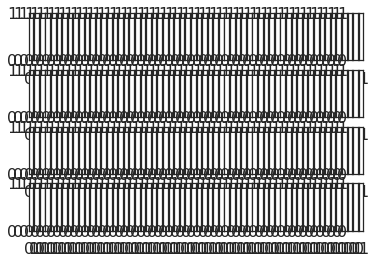

In [8]:
# Plot all stains together in a single figure
# Importing a number of different tools
from statsmodels.sandbox.stats import multicomp
import matplotlib
from matplotlib import patches
import scipy as sp
sns.set_style('white')
df.stain.unique()
%matplotlib inline

# gray 'background' of STN instead of white
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colormap', ['blue', 'lightgray', 'red'])
def plot_ellipse_values(values, ellipse_pars=None, size=(1000, 1000), vmin=None, vmax=None, cmap=plt.cm.coolwarm, ax=None, **kwargs):

    ''' values is a n-by-m array'''

    values[np.isnan(values)] = 0
    if ellipse_pars is None:
        a = 350
        b = 150
        x = 500
        y = 500

        theta = 45. / 180 * np.pi

    else:
        a, b, x, y, theta = ellipse_pars

    A = a**2 * (np.sin(theta))**2 + b**2 * (np.cos(theta))**2
    B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
    C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
    D = -2 * A * x - B* y
    E = -B * x - 2 * C * y
    F = A* x**2 + B*x*y + C*y**2 - a**2*b**2

    X,Y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

    in_ellipse = A*X**2 + B*X*Y +C*Y**2 + D*X + E*Y +F < 0

    pc1 = np.array([[np.cos(theta)], [np.sin(theta)]])
    pc2 = np.array([[np.cos(theta - np.pi/2.)], [np.sin(theta - np.pi/2.)]])

    pc1_distance = pc1.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)
    pc2_distance = pc2.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)

    pc1_quantile = np.floor((pc1_distance / a + 1 ) / 2. * values.shape[0])
    pc2_quantile = np.floor((pc2_distance / b + 1 ) / 2. * values.shape[1])

    im = np.zeros_like(X, dtype=float)

    for pc1_q in np.arange(values.shape[0]):
        for pc2_q in np.arange(values.shape[1]):
            im[in_ellipse * (pc1_quantile == pc1_q) & (pc2_quantile == pc2_q)] = values[pc1_q, pc2_q]

    im = np.ma.masked_array(im, ~in_ellipse)
#     cmap.set_bad('grey')
    if ax is None:
        cax = plt.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        cax = ax
#    sns.despine()

    return cax


# # What is the output folder for the PCA figures:
# pca_folder = '/home/mkeuken1/data/post_mortem/visualize_stains_v2/PCA_sectors/fwhm_%s' %fwhm
# if not os.path.exists(pca_folder):
#     os.makedirs(pca_folder) 

fig, axes = plt.subplots(nrows=4, ncols=3*n_sectors_per_axis)

y_type = 'rate_normalized'
# For every stain and sector over the 7 subjects plot the data and test whether it differs from zero:
for ii, (stain, d) in enumerate(df.groupby(['stain'])):
    column_set = int(np.floor(ii/4.))  # total number of columns required is n_stains / 4 (rows)
    row_n = int((ii)%4.)

    for i, (slice, d2) in enumerate(d.groupby('slice_sector')):
        print(row_n, pma_labels[::-1].index(slice) + n_sectors_per_axis*(column_set))
        ax = axes[row_n, pma_labels[::-1].index(slice) + n_sectors_per_axis*(column_set)]

        n = d2.groupby(['pc1_sector', 'pc2_sector'])[y_type].apply(lambda v: len(v)).unstack(1).ix[vmd_labels, mml_labels] #['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        t = d2.groupby(['pc1_sector', 'pc2_sector'])[y_type].apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[0]).unstack(1).ix[vmd_labels, mml_labels]#['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        p = d2.groupby(['pc1_sector', 'pc2_sector'])[y_type].apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[1]).unstack(1).ix[vmd_labels, mml_labels]
        mean = d2.groupby(['pc1_sector', 'pc2_sector']).value.mean().unstack(1).ix[vmd_labels, mml_labels]

        # FDR: as we are doing 27 seperate t-tests we need to correct for multiple comparisons:
        p.values[:] = multicomp.fdrcorrection0(p.values.ravel())[1].reshape(n_sectors_per_axis, n_sectors_per_axis)

        # Providing some parameters for plotting the figures
        if i == len(d.groupby('slice_sector'))/2:
            a, b, x, y, theta  = 350, 150, 300, 275, 45
        else:
            a, b, x, y, theta  = 300, 125, 300, 275, 45.

#         plot_ellipse_values(t[p<0.05].values, size=(600, 550), ellipse_pars=(a, b, x, y,  theta / 180. * np.pi), vmin=-7, vmax=7, cmap=cmap, ax=ax)
        plot_ellipse_values(t.values, size=(600, 550), ellipse_pars=(a, b, x, y,  theta / 180. * np.pi), vmin=-7, vmax=7, cmap=cmap, ax=ax)

        e1 = patches.Ellipse((x, y), a*2, b*2,
                             angle=theta, linewidth=2, fill=False, zorder=2)

        ax.add_patch(e1)
        ax.set_xticks([])
        ax.set_yticks([])

        sns.despine(bottom=True, left=True, right=True)

        if slice == pma_labels[int(n_sectors_per_axis/2)]: #'middle':
            ax.set_title(stain, fontsize=24)

#             print stain
#             print p.values

fig.set_size_inches(10.*2, 4.*2)
fig.subplots_adjust(hspace=.275, wspace=0.00, bottom=0.01, left=0.0, top=.95, right=1)

# outer boxes
plt.plot([0, 0], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([0, 1], [1, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([1, 1], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([0, 1], [0, 0], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)

# lines at 1/3rd, 2/3rd
plt.plot([1/3., 1/3.], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)
plt.plot([2/3., 2/3.], [0, 1], color='black', lw=1, transform=plt.gcf().transFigure, clip_on=False)

In [ ]:
mml_labels = axis_labels['mml']
#pma_labels = axis_labels['pma']
vmd_labels = axis_labels['vmd']

def visualize_intensity_across_space(df, dependent_var = 'y', per_slice = True):
            
    # loop
    if per_slice:  # (again ugly but ok)
        n_slices = df['slice_sector_coordinate'].unique().shape[0]
        pma_labels = df['slice_sector'].unique()
        f, ax = plt.subplots(2, n_slices)

        vmin = df[dependent_var].min()
        vmax = df[dependent_var].max()
        for i, pma_slice in enumerate(pma_labels):
            idx = df.slice_sector == pma_slice
            
            unstacked = df.loc[idx].groupby(['pc1_sector', 'pc2_sector'])[dependent_var].mean().unstack(1).ix[vmd_labels, mml_labels]
            plot_ellipse_values(unstacked.values, ax=ax[0,i], vmin=vmin, vmax=vmax)
            ax[0,i].axis('off')

            # select values on mid-line of vmd-axis, so set mml to midline
            data_per_coordinate = df.loc[idx].groupby(['pc1_sector_coordinate'])[dependent_var].mean()
            ax[1,i].plot(np.arange(n_slices-1), data_per_coordinate)

        y_lims = np.empty((n_slices, 2))
        for sl in np.arange(n_slices):
            y_lims[sl, 0] = ax[1,sl].get_ylim()[0]
            y_lims[sl, 1] = ax[1,sl].get_ylim()[1]

        for sl in np.arange(n_slices):
            ax[1,sl].set_ylim([y_lims.min(0)[0], y_lims.max(0)[1]])
            ax[1,sl].tick_params(axis='x', which='both', bottom=False, top=False, left=False, labelbottom=False)
            ax[1,sl].get_yaxis().set_visible(False)
    else:
        f, ax = plt.subplots(2, 1)
        unstacked = df.groupby(['pc1_sector', 'pc2_sector'])[dependent_var].mean().unstack(1).ix[vmd_labels, mml_labels]
        plot_ellipse_values(unstacked.values, ax=ax[0])
        ax[0].axis('off')

        # select values on mid-line of vmd-axis, so set mml to midline
        data_per_coordinate = df.groupby(['pc1_sector_coordinate'])[dependent_var].mean()
        ax[1].plot(np.arange(data_per_coordinate.shape[0]), data_per_coordinate)

    f.set_size_inches(ax.ravel().shape[0], 6)
    f.suptitle('12x12x12 voxels')
        
visualize_intensity_across_space(df.loc[(df.subject_id==13095) & (df.stain=='CALR')], dependent_var='rate', per_slice=True)

In [ ]:
visualize_intensity_across_space(df.loc[(df.subject_id==13095) & (df.stain=='CALR')], dependent_var='rate', per_slice=False)

## Model specifications

|Model N | Specification | Parameters | Interpretation |
|--------|:------------- |:---------- | ---------------|
| 1a | log(y) ~ 1, $\epsilon \sim Poisson$| $\beta_{intercept}$ | No change in expression across space |
| 1b | log(y) ~ 1, $\epsilon \sim NegativeBinomial$| $\beta_{intercept}$, $\alpha$ | No change in expression across space |
| 2a | log(y) ~ pc_1, $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{pc_1}$ | Linear change across principal component 1 |
| 2b | log(y) ~ pc_1, $\epsilon \sim NegativeBinomial$ | $\beta_{intercept}$, $\beta_{pc_1}$, $\alpha$ | Linear change across principal component 1 |
| 3a | log(y) ~ sector, $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$ | 3 sectors, equisized
| 3b | log(y) ~ sector, $\epsilon \sim NegativeBinomial$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, $\alpha$ |  3 sectors, equisized
| 4a | log(y) ~ pc_1 + pc_2 + pc_3, $\epsilon \sim Poisson$ | $\beta_{intercept}$,  $\beta_{pc_1}$, $\beta_{pc_2}$, $\beta_{pc_3}$ |  Linear change in 3 directions
| 4b | log(y) ~ pc_1 + pc_2 + pc_3, $\epsilon \sim NegativeBinomial$ | $\beta_{intercept}$,  $\beta_{pc_1}$, $\beta_{pc_2}$, $\beta_{pc_3}$, $\alpha$ | Linear change in 3 directions
| 5a | log(y) ~ sector, $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, cutoff1, cutoff2 | 3 sectors, cut-off estimated
| 5b | log(y) ~ sector, $\epsilon \sim NegativeBinomial$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, cutoff1, cutoff2, $\alpha$ |  3 sectors, cut-off estimated
| 6a | log(y) ~ sector, $\epsilon \sim Poisson$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, $\beta_{pc_1}$, $\beta_{pc_2}$, $\beta_{pc_3}$, cutoff1, cutoff2 | 3 sectors, cut-off estimated along projected axis
| 6b | log(y) ~ sector, $\epsilon \sim NegativeBinomial$ | $\beta_{intercept}$, $\beta_{sector1}$, $\beta_{sector2}$, $\beta_{pc_1}$, $\beta_{pc_2}$, $\beta_{pc_3}$, cutoff1, cutoff2, $\alpha$ |  3 sectors, cut-off estimated along projected axis

In [ ]:
# check-out distribution choice: does a Poisson distribution fit the data?

In [33]:
import pymc3 as pm

# exposure = df.loc[(df.subject_id==13095) & (df.stain=='CALR'), 'n_voxels'].copy().values
y = np.round(df.loc[(df.subject_id==13095) & (df.stain=='FER'), 'rate'].copy().values)

with pm.Model() as model:
    
    intercept = pm.Normal('intercept', mu=0, sd=10)
    
    ev = intercept
    likelihood = pm.Poisson('y', mu=np.exp(intercept), observed=y)
    
traces = pm.sample(model=model, tuning=1000, cores=11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (11 chains in 11 jobs)
NUTS: [intercept]
Sampling 11 chains: 100%|██████████| 11000/11000 [00:03<00:00, 2754.37draws/s]
The acceptance probability does not match the target. It is 0.8918820224260972, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860258246203231, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913547697536173, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.896841369059218, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9093751778423127, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probabil

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6398cf9550>,
      dtype=object)

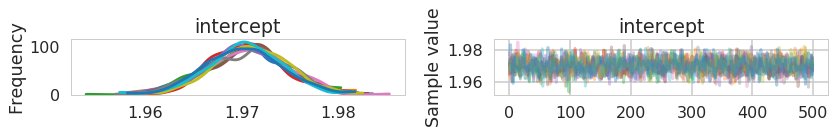

In [34]:
pm.traceplot(traces)

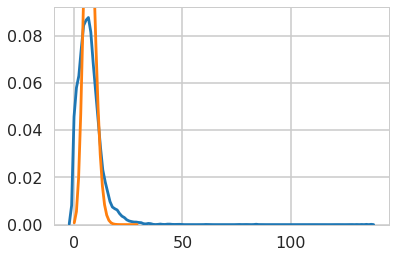

In [36]:
import scipy as sp
sns.kdeplot(np.round(y))
plt.plot(np.arange(30), sp.stats.poisson.pmf(np.arange(30), mu=np.exp(pm.summary(traces).loc['intercept', 'mean'])))

Ok, so at least model 1 seems to fit reasonably well. Poisson may not be such a bad choice

In [37]:
df.head()

subject_id  slice_sector               pc1_sector               pc2_sector  \
0       13095             1  vmd_-0.4749999999999999  mml_-0.4749999999999999   
1       13095             5  vmd_-0.4749999999999999  mml_-0.4749999999999999   
2       13095             6  vmd_-0.4749999999999999  mml_-0.4749999999999999   
3       13095             7  vmd_-0.4749999999999999  mml_-0.4749999999999999   
4       13095             8  vmd_-0.4749999999999999  mml_-0.4749999999999999   

   n_voxels stain   value       rate  rate_normalized  pc1_sector_coordinate  \
0        32  CALR   354.0  11.062500         2.790555                 -0.475   
1        52  CALR   326.0   6.269231         1.358276                 -0.475   
2        93  CALR     7.0   0.075269        -0.492544                 -0.475   
3       133  CALR   694.0   5.218045         1.044171                 -0.475   
4       139  CALR  1265.0   9.100719         2.204354                 -0.475   

   pc2_sector_coordinate  
0                 -0.475  
1                 -0.475  
2                 -0.475  
3                 -0.475  
4                 -0.475

### Non-hierarchical

In [53]:
# code for smooth switch point:
# https://gist.github.com/junpenglao/f7098c8e0d6eadc61b3e1bc8525dd90d
import theano.tensor as tt
from pymc3.distributions.transforms import ElemwiseTransform, Transform

class Ordered(ElemwiseTransform):
    name = "ordered"

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out

    def forward_val(self, x, point=None):
        x, = draw_values([x], point=point)
        return self.forward(x)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

ordered = Ordered()


class Composed(Transform):
    def __init__(self, transform1, transform2):
        self._transform1 = transform1
        self._transform2 = transform2
        self.name = '_'.join([transform1.name, transform2.name])

    def forward(self, x):
        return self._transform2.forward(self._transform1.forward(x))

    def forward_val(self, x, point=None):
        return self.forward(x)

    def backward(self, y):
        return self._transform1.backward(self._transform2.backward(y))

    def jacobian_det(self, y):
        y2 = self._transform2.backward(y)
        det1 = self._transform1.jacobian_det(y2)
        det2 = self._transform2.jacobian_det(y)
        return det1 + det2
    
# def logistic(L, x0, t_, k=500, min_voxel_size=4):
#     x0 = min_voxel_size/2. + (x0*(np.ptp(t_)-min_voxel_size))  # to sector_number-space instead of [0,1]
#     return L/(1+np.exp(-k*(t_-x0)))

# def reverse_logistic(L, x0, t_, k=500, min_voxel_size=4):
#     x0 = min_voxel_size/2. + (x0*(np.ptp(t_)-min_voxel_size))
#     return L/(1+np.exp(-k*(x0-t_)))

def logistic(L, x0, k=500, t_=np.linspace(0., 1., 1000)):
    return L/(1+tt.exp(-k*(t_-x0)))

In [15]:
import pandas as pd
# Minor prepping of df
id_dict = dict([(id_old, id_new) for id_new, id_old in enumerate(df.subject_id.unique())])
df['subject_id_2'] = df['subject_id'].replace(id_dict)  # id_2 is 0,1,2,3,4,5, used as actual indices [sorry, ugly name]

# define y
df['y'] = np.round(df['rate'])

# Get sectors for Tripartite model
df['x_tripartite_axis_1'] = pd.qcut(df['pc1_sector_coordinate'].values, 3, labels=[1,2,3])
df['x_tripartite_axis_2'] = pd.qcut(df['pc2_sector_coordinate'].values, 3, labels=[1,2,3])
# df['x_tripartite_axis_slice'] = pd.qcut(df['slice_sector_coordinate'].values, 3, labels=[1,2,3])
df['x_tripartite_axis_slice'] = pd.qcut(df['slice_sector'].values, 3, labels=[1,2,3])


# get sector numbers
df['pc1_sector_number'] = df['pc1_sector_coordinate'].replace(dict(zip(df['pc1_sector_coordinate'].unique(), np.arange(df['pc1_sector_coordinate'].unique().shape[0]))))
df['pc2_sector_number'] = df['pc2_sector_coordinate'].replace(dict(zip(df['pc2_sector_coordinate'].unique(), np.arange(df['pc2_sector_coordinate'].unique().shape[0]))))
# df['slice_sector_number'] = df['slice_sector_coordinate'].replace(dict(zip(df['slice_sector_coordinate'].unique(), np.arange(df['slice_sector_coordinate'].unique().shape[0]))))


In [16]:
# prep output dataframe
models = ['1', '2', '3', '4', '5', '6']
stains = df.stain.unique()
distributions = ['poisson', 'negative_binomial']
subjects = df.subject_id.unique()

model_flat_df = pd.DataFrame(columns=['model', 'trace'], 
                             index=pd.MultiIndex.from_product([subjects, distributions, stains, models], 
                                                               names=['subject_id', 'dist', 'stain', 'model_n']))

In [75]:
import pymc3 as pm
overwrite = False

for dist in distributions:
    for stain in stains:
        for subj in df.subject_id.unique():
            # select data / idx
            print('{} {} {}'.format(dist, stain, subj))
            y = np.round(df.loc[(df.subject_id==subj) & (df.stain==stain), 'rate'].copy().values)
            indx = (df.subject_id==subj) & (df.stain==stain)

            for model_n in [5]:
                
                # check if already exists
                if pd.notnull(model_flat_df.loc[((subj, dist, stain, str(model_n)), 'trace')]) and not overwrite:
                    continue

                print('Model {}'.format(model_n))
                with pm.Model() as model:
                    intercept = pm.Normal('intercept', mu=1, sd=3)
                    
                    if model_n == 1:
                        # no change
                        ev = np.exp(intercept)
                    
                    elif model_n == 2:
                        # gradient along pc axis 1
                        beta_pca_1 = pm.Normal('beta_pca_1', mu=0, sd=3)
                        ev = np.exp(intercept + beta_pca_1*df.loc[indx, 'pc1_sector_coordinate'].values)
                        
                    elif model_n == 3:
                        # 3 sectors along pc axis 1
                        delta_center_1 = pm.Normal('delta_center_1', mu=0, sd=3)
                        delta_center_3 = pm.Normal('delta_center_3', mu=0, sd=3)

                        ev = np.exp(intercept + \
                                    delta_center_1*((df.loc[indx, 'x_tripartite_axis_1'].values==1).astype(int)) + \
                                    delta_center_3*((df.loc[indx, 'x_tripartite_axis_1'].values==3).astype(int)))
                    
                    elif model_n == 4:
                        # gradient along pc axis 1+2+3
                        beta_pca_1 = pm.Normal('beta_pca_1', mu=0, sd=3)
                        beta_pca_2 = pm.Normal('beta_pca_2', mu=0, sd=3)
                        beta_slice = pm.Normal('beta_slice', mu=0, sd=3)
                        
                        # np.cdot() # betas met coordinaten  ->  coordinaat op deze nieuwe as
                        # # cut_off op die as [0,1]
                        # # per voxel bepalen welke sector
                        
                        ev = np.exp(intercept + beta_pca_1*df.loc[indx, 'pc1_sector_coordinate'].values + \
                                    beta_pca_2*df.loc[indx, 'pc2_sector_coordinate'].values + \
                                    beta_slice*df.loc[indx, 'slice_sector_coordinate'].values)
                        
                    elif model_n == 5:
                        nbreak = 3
#                        lambda0 = pm.Normal('lambda0', 0, sd=3)
                        k = pm.Normal('k', mu=10, sd=3)
                        lambdad = pm.Normal('lambdad', 0, sd=3, shape=3-1)
                        trafo = Composed(pm.distributions.transforms.LogOdds(), Ordered())
                        b = pm.Beta('b', 1., 1., shape=nbreak-1, transform=trafo,
                                    testval=[0.3, 0.67])
#                         b = pm.Beta('cut_offs', 1., 1., shape=2, transform=Ordered(), testval=[0.33, 0.67])
#                         tau_1 = pm.Beta('cut_off_1', alpha=3, beta=11)#, 
# #                                        transform=pm.distributions.transforms.LogOdds())
#                         tau_2 = pm.Beta('cut_off_2', alpha=11, beta=3)#
# #                                        transform=pm.distributions.transforms.LogOdds())
                        ev = np.exp(intercept + logistic(lambdad[0], b[0], k=k, t_=df.loc[indx, 'pc1_sector_coordinate'].values) +
                                                logistic(lambdad[1], b[1], k=k, t_=df.loc[indx, 'pc1_sector_coordinate'].values))
                        
#                         obs = pm.Poisson('obs', theta_, observed=y)
                        
#                     elif model_n == 5:
#                         # 3 sectors along pc axis 1, cut-offs estimated
#                         delta_center_1 = pm.Normal('delta_center_1', mu=1, sd=3)
#                         delta_center_3 = pm.Normal('delta_center_3', mu=1, sd=3)
                        
# #                         tau_1 = pm.Uniform('cut_off_1', lower=1, upper=9)
# #                         tau_2 = pm.Uniform('cut_off_2', lower=10, upper=18)
#                         tau_1 = pm.Categorical('cut_off_1', 
#                                                np.array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
#                         tau_2 = pm.Categorical('cut_off_2', 
#                                                np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))
#                         # uniform priors
                    
#                         sector_numbers = df.loc[indx, 'pc1_sector_number'].values
#                         is_sector_1 = pm.math.switch(sector_numbers < tau_1, delta_center_1, 0)
#                         is_sector_2 = pm.math.switch((tau_2 >= sector_numbers) & (sector_numbers >= tau_1), intercept, 0)
#                         is_sector_3 = pm.math.switch(sector_numbers > tau_2, delta_center_3, 0)
                        
#                         ev = np.exp(is_sector_1 + is_sector_2 + is_sector_3)
                        
#                     elif model_n == 5:
#                         # 3 sectors along pc axis 1, cut-offs estimated
#                         center_1 = pm.Normal('center_1', mu=1, sd=3)
#                         center_3 = pm.Normal('center_3', mu=1, sd=3)
                        
# #                         tau_1 = pm.Beta('cut_off_1', alpha=3, beta=11)
# #                         tau_2 = pm.Beta('cut_off_2', alpha=11, beta=3)
#                         tau_1 = pm.Categorical('cut_off_1', 
#                                                np.array([0, 1, 2, 3, 3, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
#                         tau_2 = pm.Categorical('cut_off_2', 
#                                                np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 2, 1, 1, 0]))
#                         # with priors
                        
#                         sector_numbers = df.loc[indx, 'pc1_sector_number'].values #/20.
#                         is_sector_1 = pm.math.switch(sector_numbers < tau_1, center_1, 0)
#                         is_sector_2 = pm.math.switch((tau_2 <= sector_numbers) & (sector_numbers <= tau_1), intercept, 0)
#                         is_sector_3 = pm.math.switch(sector_numbers > tau_2, center_3, 0)
                        
#                         ev = np.exp(is_sector_1 + is_sector_2 + is_sector_
        
                    # define likelihood
                    if dist == 'poisson':
                        likelihood = pm.Poisson('y', mu=ev, observed=y)
                    else:
                        alpha = pm.HalfCauchy('alpha', beta=2)
                        likelihood = pm.NegativeBinomial('y', mu=ev, alpha=alpha, observed=y)
                        
                    model.name = str(model_n) + '_' + dist
                    model_flat_df.loc[((subj, dist, stain, str(model_n)), 'model')] = model
#                     traces = pm.sample(tune=2000, draws=2000, cores=11, target_accept=.9)
                    traces = pm.sample(cores=11)
                    model_flat_df.loc[((subj, dist, stain, str(model_n)), 'trace')] = traces
                    

poisson CALR 13095
poisson CALR 14037
poisson CALR 14051
poisson CALR 14069
poisson CALR 15033
Model 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (11 chains in 11 jobs)
NUTS: [b_logodds, lambdad, k, intercept]
Sampling 11 chains:  22%|██▏       | 2463/11000 [02:47<09:39, 14.74draws/s]


ValueError: Not enough samples to build a trace.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c9599a3c8>,
      dtype=object)

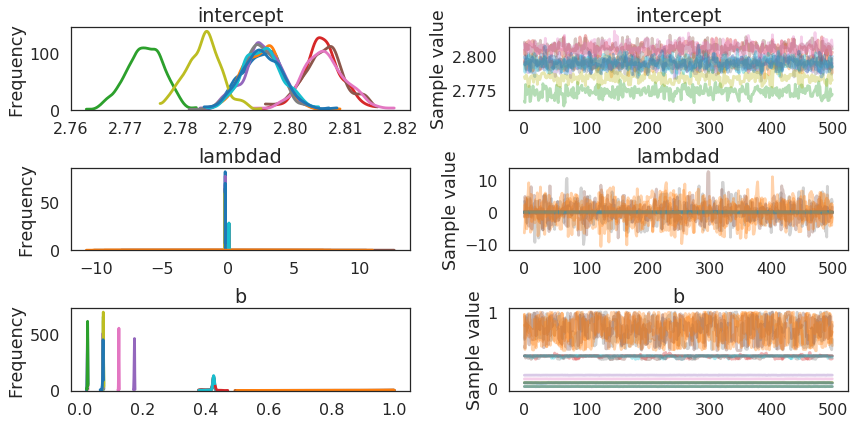

In [59]:
pm.traceplot(model_flat_df.loc[((14069, dist, stain, str(model_n)), 'trace')], ['intercept', 'lambdad', 'b'])

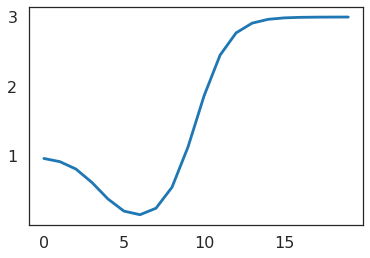

In [74]:
indx = (df.subject_id == 13095) & (df.stain == 'CALR')

ts = df.loc[indx, 'pc1_sector_number'].unique()

def logistic(L, x0, t_, k=10, min_voxel_size=4):
    x0 = min_voxel_size/2. + (x0*(np.ptp(t_)-min_voxel_size))
    return L/(1+np.exp(-k*(t_-x0)))

def reverse_logistic(L, x0, t_, k=10, min_voxel_size=4):
    x0 = min_voxel_size/2. + (x0*(np.ptp(t_)-min_voxel_size))
    return L/(1+np.exp(-k*(x0-t_)))

intercept = 0
d1 = 1
d2 = 3
#plt.plot(ts, logistic(1, .1, 500, ts))
k = 1
plt.plot(ts, intercept + reverse_logistic(d1, .1, ts, k) + logistic(d2, .5, ts, k))

OK so model 5 is messed up

save all fitted models

In [ ]:
pm.traceplot(model_flat_df.loc[((13095, dist, stain, str(model_n)), 'trace')])

KeyboardInterrupt: 

In [ ]:
import pickle as pkl
model_save_dir = './glm_models_20sectors'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

model_flat_df2 = model_flat_df.copy()
model_flat_df2 = model_flat_df2.reset_index()  # reset index is easier for looping

for row_n in np.arange(model_flat_df2.shape[0]):
    row = model_flat_df2.iloc[row_n]
    
    subj, dist, stain, model_n, model, trace = row[['subject_id', 'dist', 'stain', 'model_n', 'model', 'trace']].values
    model_fn = os.path.join(model_save_dir, 
                           'sub-{}_dist-{}_stain-{}_model-{}_model.pkl'.format(subj, dist, stain, model_n))
    trace_fn = os.path.join(model_save_dir, 
                           'sub-{}_dist-{}_stain-{}_model-{}_trace.pkl'.format(subj, dist, stain, model_n))
    
    if not os.path.exists(model_fn) and pd.notnull(model):
        with open(model_fn, 'wb') as f:
            pkl.dump(model, f)
            
    if not os.path.exists(trace_fn) and pd.notnull(trace):
        with open(trace_fn, 'wb') as f:
            pkl.dump(trace, f)

load back in

In [189]:
import glob
import re
fns = glob.glob('glm_models/*')

In [197]:
# rebuild df
models = ['1', '2', '3', '4', '5']
stains = df.stain.unique()
distributions = ['poisson', 'negative_binomial']
subjects = df.subject_id.unique()

model_flat_df = pd.DataFrame(columns=['model', 'trace'], 
                             index=pd.MultiIndex.from_product([subjects, distributions, stains, models], 
                                                               names=['subject_id', 'dist', 'stain', 'model_n']))

In [202]:
tmp = model_flat_df.reset_index().copy()
for row_n in np.arange(tmp.shape[0]):
    row = tmp.iloc[row_n]
    
    subj, dist, stain, model_n = row[['subject_id', 'dist', 'stain', 'model_n']].values
    indx = (subj, dist, stain, model_n)

    model_fn = os.path.join(model_save_dir, 
                           'sub-{}_dist-{}_stain-{}_model-{}_model.pkl'.format(subj, dist, stain, model_n))
    trace_fn = os.path.join(model_save_dir, 
                           'sub-{}_dist-{}_stain-{}_model-{}_trace.pkl'.format(subj, dist, stain, model_n))
    
    if os.path.exists(model_fn):
        with open(model_fn, 'rb') as f:
            model_flat_df.loc[(indx, 'model')] = pkl.load(f)
    if os.path.exists(trace_fn):
        with open(trace_fn, 'rb') as f:
            model_flat_df.loc[(indx, 'trace')] = pkl.load(f)

In [142]:
model_flat_df

model  \
subject_id dist              stain   model_n                                                 
13095      poisson           CALR    1        <pymc3.model.Model object at 0x7f63a6600048>   
                                     2        <pymc3.model.Model object at 0x7f6394d15438>   
                                     3        <pymc3.model.Model object at 0x7f63aae6a080>   
                                     4        <pymc3.model.Model object at 0x7f642c1751d0>   
                                     5        <pymc3.model.Model object at 0x7f63aa7ad908>   
                                     6        <pymc3.model.Model object at 0x7f63aba696a0>   
                             FER     1        <pymc3.model.Model object at 0x7f6440d32780>   
                                     2        <pymc3.model.Model object at 0x7f63981c4860>   
                                     3        <pymc3.model.Model object at 0x7f63e73e8f28>   
                                     4        <pymc3.model.Model object at 0x7f63e781ea90>   
                                     5        <pymc3.model.Model object at 0x7f63e624a780>   
                                     6        <pymc3.model.Model object at 0x7f63e5de7630>   
                             GABRA3  1        <pymc3.model.Model object at 0x7f63a2a956a0>   
                                     2        <pymc3.model.Model object at 0x7f63a329d550>   
                                     3        <pymc3.model.Model object at 0x7f63a3f89dd8>   
                                     4        <pymc3.model.Model object at 0x7f6440011be0>   
                                     5        <pymc3.model.Model object at 0x7f63aacf6c18>   
                                     6        <pymc3.model.Model object at 0x7f63e7759588>   
                             GAD6567 1        <pymc3.model.Model object at 0x7f63a160ba58>   
                                     2        <pymc3.model.Model object at 0x7f6424235208>   
                                     3        <pymc3.model.Model object at 0x7f63e54384e0>   
                                     4        <pymc3.model.Model object at 0x7f63a36dba90>   
                                     5        <pymc3.model.Model object at 0x7f63a2803908>   
                                     6        <pymc3.model.Model object at 0x7f63a19b6d30>   
                             MBP     1        <pymc3.model.Model object at 0x7f638b1a3978>   
                                     2        <pymc3.model.Model object at 0x7f639918eeb8>   
                                     3        <pymc3.model.Model object at 0x7f63a2107198>   
                                     4        <pymc3.model.Model object at 0x7f63e6ff6588>   
                                     5        <pymc3.model.Model object at 0x7f63a3e87080>   
                                     6        <pymc3.model.Model object at 0x7f63a10773c8>   
...                                                                                    ...   
15055      negative_binomial SMI32   1        <pymc3.model.Model object at 0x7f634258ec88>   
                                     2        <pymc3.model.Model object at 0x7f6328f8ab38>   
                                     3        <pymc3.model.Model object at 0x7f6335e72d30>   
                                     4        <pymc3.model.Model object at 0x7f633c09dc50>   
                                     5        <pymc3.model.Model object at 0x7f63276cfef0>   
                                     6        <pymc3.model.Model object at 0x7f632a5f3748>   
                             SYN     1        <pymc3.model.Model object at 0x7f6321de5c50>   
                                     2        <pymc3.model.Model object at 0x7f6321655160>   
                                     3        <pymc3.model.Model object at 0x7f6337791f28>   
                                     4        <pymc3.model.Model object at 0x7f633a657eb8>   
                                     5     

#### Visually compare negative binomial vs poisson fit

The specimen & stains with higher expression rates are interesting to inspect

In [143]:
pm.summary(model_flat_df.loc[((15055, 'negative_binomial', 'CALR', '1'), 'trace')])

mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
intercept  3.161006  0.006515  0.000048  3.148335  3.173634  22005.319428   
alpha      2.318456  0.032814  0.000245  2.256297  2.385529  22401.382577   

               Rhat  
intercept  1.000046  
alpha      1.000130

In [144]:
pm.summary(model_flat_df.loc[((15055, 'poisson', 'CALR', '1'), 'trace')])

mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
intercept  3.160998  0.001951   0.00002  3.157191   3.16483  10331.511781   

               Rhat  
intercept  0.999999

In [145]:
pm.waic(trace=model_flat_df.loc[((15055, 'poisson', 'CALR', '1'), 'trace')], 
        model=model_flat_df.loc[((15055, 'poisson', 'CALR', '1'), 'model')])

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


WAIC_r(WAIC=169456.4464608176, WAIC_se=1452.2493195168327, p_WAIC=10.899771198902542, var_warn=0)

In [146]:
pm.waic(trace=model_flat_df.loc[((15055, 'negative_binomial', 'CALR', '1'), 'trace')], 
        model=model_flat_df.loc[((15055, 'negative_binomial', 'CALR', '1'), 'model')])

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


WAIC_r(WAIC=90598.6294827629, WAIC_se=156.697895098543, p_WAIC=1.8456910776881466, var_warn=0)

In [147]:
from scipy import special
import scipy as sp

def NegBinom(a, m, x):
    pmf = special.binom(x + a - 1, x) * (a / (m + a))**a * (m / (m + a))**x
    return pmf

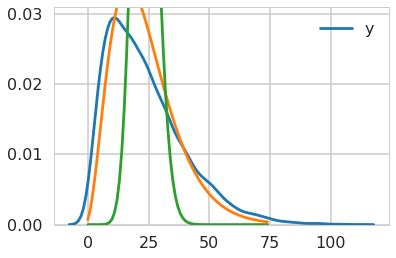

In [148]:
sns.kdeplot(df.loc[(df.subject_id==15055) & (df.stain == 'CALR'), 'y'])
plt.plot(np.arange(75), NegBinom(a=3.6, x=np.arange(75), m=np.exp(3.16)))
plt.plot(np.arange(75), sp.stats.poisson.pmf(np.arange(75), mu=np.exp(3.162835)))

for these larger expression values, a negative binomial clearly fits better than a poisson

Compare more formally. This takes a bit of time

In [ ]:
def comp(x):
    if pd.isnull(x['trace']).sum()>0:
        return np.nan
    
    print('Comparing...')
    comparison = pm.compare(dict(zip(x['model'].values, x['trace'].values)))
    
    return comparison

# ensure model names are unique, both attributes and values in column "model_n"
for row in np.arange(model_flat_df.reset_index().shape[0]):
    model = model_flat_df.reset_index().iloc[row]['model']
    model.name = model_flat_df.reset_index().iloc[row]['model_n'] + '_' + model_flat_df.reset_index().iloc[row]['dist']

compares = model_flat_df.reset_index()
compares['model_n'] = compares['model_n'] + '_' + compares ['dist']  # rename model_n columns to prevent pandas from averaging(?) across distribution types
compares = compares.groupby(['subject_id', 'stain']).apply(lambda x: comp(x))

In [ ]:
compares.to_pickle(os.path.join(model_save_dir, 'comparison.pkl'))

In [149]:
# inspect to see if the results make some sense
compares.loc[(13095, 'CALR')]

WAIC  pWAIC    dWAIC weight      SE     dSE var_warn
4_negative_binomial  24900.3  11.34        0   0.79  298.24       0        1
2_negative_binomial    27465   3.12   2564.7      0  261.98  165.51        0
3_negative_binomial  27527.7   4.13  2627.33   0.05  262.76  166.12        0
5_negative_binomial  27636.2   5.11  2735.83   0.13  276.71  169.42        0
6_negative_binomial  27636.5   5.52  2736.15   0.15  276.71  169.41        0
1_negative_binomial    27741    2.1  2840.63      0  265.12  171.19        0
4_poisson            30938.8  19.81  6038.42   0.23  606.01  381.04        1
2_poisson            43710.2  13.26  18809.8   0.05  807.61     690        0
3_poisson            44198.8  18.17  19298.4   0.05   829.3  712.77        0
6_poisson            44610.2  18.89  19709.8   0.05  876.24  748.61        1
5_poisson            44610.3  18.99  19709.9   0.05  876.23  748.59        1
1_poisson            45554.3   6.65    20654      0  891.94  782.83        0

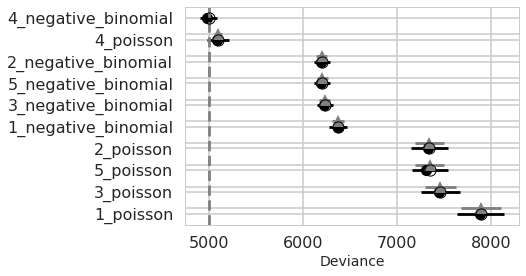

In [254]:
pm.compareplot(compares.loc[(13095, 'CALR')])

In [151]:
compares

WAIC  pWAIC    dWAIC weight  \
subject_id stain  model_n                                               
13095      CALR   4_negative_binomial  24900.3  11.34        0   0.79   
                  2_negative_binomial    27465   3.12   2564.7      0   
                  3_negative_binomial  27527.7   4.13  2627.33   0.05   
                  5_negative_binomial  27636.2   5.11  2735.83   0.13   
                  6_negative_binomial  27636.5   5.52  2736.15   0.15   
                  1_negative_binomial    27741    2.1  2840.63      0   
                  4_poisson            30938.8  19.81  6038.42   0.23   
                  2_poisson            43710.2  13.26  18809.8   0.05   
                  3_poisson            44198.8  18.17  19298.4   0.05   
                  6_poisson            44610.2  18.89  19709.8   0.05   
                  5_poisson            44610.3  18.99  19709.9   0.05   
                  1_poisson            45554.3   6.65    20654      0   
           FER    4_negative_binomial  49153.5    6.7        0   0.57   
                  2_negative_binomial  49433.8   4.02   280.29      0   
                  3_negative_binomial  49450.8   5.09   297.26      0   
                  1_negative_binomial  49537.2   2.98   383.71      0   
                  5_negative_binomial  61212.4    3.6  12058.9   0.11   
                  6_negative_binomial  61212.5   3.66    12059      0   
                  4_poisson            61457.5  18.93    12304   0.32   
                  2_poisson            62539.1   9.22  13385.6      0   
                  3_poisson            62605.7  13.61  13452.2      0   
                  1_poisson            62969.2   4.64  13815.8      0   
                  5_poisson              96008  13.65  46854.6      0   
                  6_poisson            96008.1  13.67  46854.6      0   
           GABRA3 4_negative_binomial  61358.4   5.32        0   0.87   
                  2_negative_binomial  61811.1   2.91    452.7      0   
                  3_negative_binomial  61816.4   3.89   458.01   0.01   
                  1_negative_binomial  61959.4   1.95   601.02   0.06   
                  6_negative_binomial  84141.4   3.84    22783   0.01   
                  5_negative_binomial  84141.4   3.89  22783.1      0   
...                                        ...    ...      ...    ...   
15055      TH     4_poisson            84229.3  48.05  35121.5   0.19   
                  2_poisson             150957  43.07   101849      0   
                  3_poisson             151047  68.75   101939      0   
                  1_poisson             151219  23.31   102111      0   
                  5_poisson             173317  70.37   124209      0   
                  6_poisson             173318  70.32   124210      0   
           TRANSF 4_negative_binomial  85970.6   6.58        0   0.76   
                  2_negative_binomial  86340.1   3.64   369.58      0   
                  3_negative_binomial  86494.3   4.53   523.77      0   
                  1_negative_binomial  87332.2   2.34   1361.7   0.11   
                  4_poisson             110109  21.59    24138   0.13   
                  2_poisson             111894  10.19  25923.5      0   
                  3_poisson             112612  15.09  26641.4      0   
                  1_poisson             117104   5.41  31133.4      0   
                  6_negative_binomial   142288   2.82  56317.8      0   
                  5_negative_binomial   142288   2.83  56317.8      0   
                  5_poisson             497286  15.09   411316      0   
                  6_poisson             497286  15.11   411316      0   
           VGLUT1 4_negative_binomial  86712.8   5.72        0   0.71   
                  3_negative_binomial  86881.9   4.48   169.08   0.11   
                  2_negative_binomial  86949.7   3.68    236.9      0   
                  1_negative_binomial  86982.1   2.68    269.3      0   
                  4_poisson

In [150]:
# find winning model per subj/stain combination
compares.index.set_names(['subject_id', 'stain', 'model_n'], inplace=True)
winning_models = compares.reset_index().groupby(['subject_id', 'stain']).apply(lambda x: x.model_n.iloc[0]).reset_index()
winning_models.columns = ['subject_id', 'stain', 'winner']
winning_models.pivot_table(index='subject_id', values='winner', columns='stain', aggfunc=lambda x: x)

stain                      CALR                  FER               GABRA3  \
subject_id                                                                  
13095       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14037       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14051       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14069       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15033       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15055       4_negative_binomial  4_negative_binomial  4_negative_binomial   

stain                   GAD6567                  MBP                 PARV  \
subject_id                                                                  
13095       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14037       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14051       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14069       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15033       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15055       4_negative_binomial  4_negative_binomial  4_negative_binomial   

stain                      SERT                SMI32                  SYN  \
subject_id                                                                  
13095       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14037       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14051       4_negative_binomial  4_negative_binomial  4_negative_binomial   
14069       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15033       4_negative_binomial  4_negative_binomial  4_negative_binomial   
15055       4_negative_binomial  4_negative_binomial  4_negative_binomial   

stain                        TH               TRANSF               VGLUT1  
subject_id                                                                 
13095       4_negative_binomial  4_negative_binomial  4_negative_binomial  
14037       4_negative_binomial  4_negative_binomial  4_negative_binomial  
14051       4_negative_binomial  4_negative_binomial  4_negative_binomial  
14069       4_negative_binomial  4_negative_binomial  4_negative_binomial  
15033       4_negative_binomial  4_negative_binomial  4_negative_binomial  
15055       4_negative_binomial  4_negative_binomial  4_negative_binomial

Interesting: By far most prefer model 4 with negative binomial distributed errors. What about the other ones?

Especially inspect 15033/MBP and 13095/VGLUT1, where a three-partite model seems to win

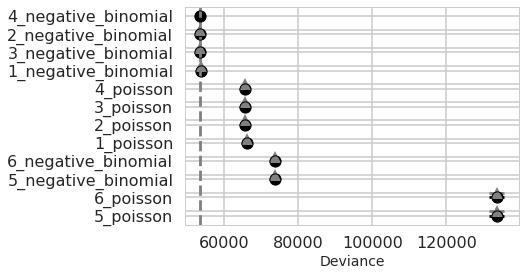

In [155]:
pm.compareplot(compares.loc[(13095, 'VGLUT1')])

In [157]:
model_flat_df.head()

model  \
subject_id dist    stain model_n                                                 
13095      poisson CALR  1        <pymc3.model.Model object at 0x7f63a6600048>   
                         2        <pymc3.model.Model object at 0x7f6394d15438>   
                         3        <pymc3.model.Model object at 0x7f63aae6a080>   
                         4        <pymc3.model.Model object at 0x7f642c1751d0>   
                         5        <pymc3.model.Model object at 0x7f63aa7ad908>   

                                                                              trace  
subject_id dist    stain model_n                                                     
13095      poisson CALR  1        ({'intercept': 0.538591518017738}, {'intercept...  
                         2        ({'intercept': 0.461353633741647, 'beta_pca_1'...  
                         3        ({'intercept': 0.4223620488151394, 'delta_cent...  
                         4        ({'intercept': 0.13610153876363437, 'beta_pca_...  
                         5        ({'intercept': 0.3953211996373803, 'cut_off_1'...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6314f989e8>,
      dtype=object)

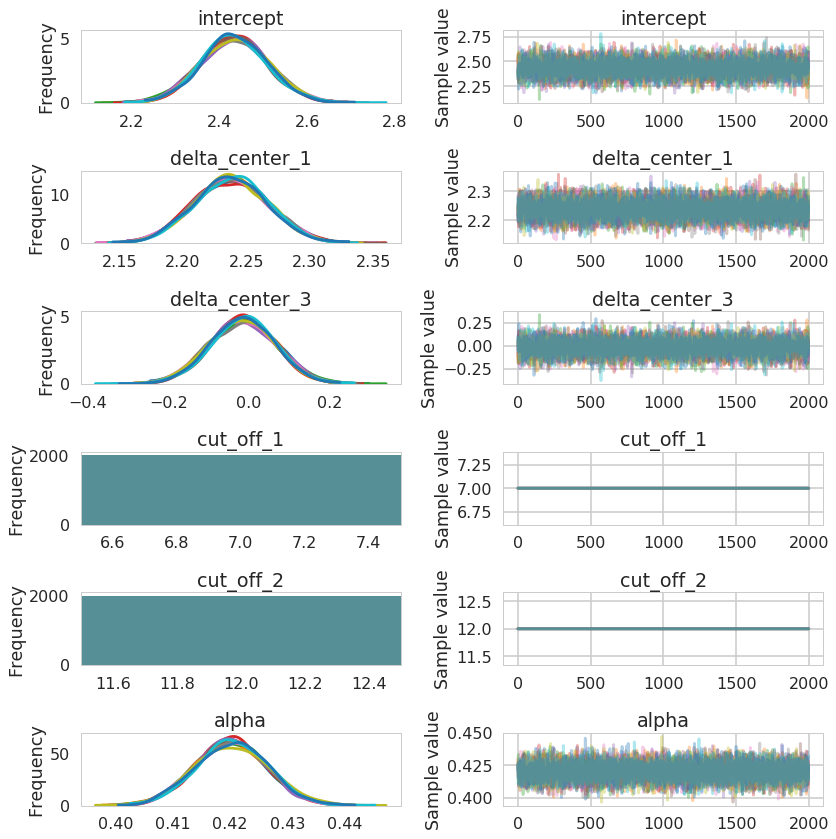

In [161]:
pm.traceplot(model_flat_df.loc[((13095, 'negative_binomial', 'VGLUT1', '6'), 'trace')])

In [152]:
visualize_intensity_across_space(df.loc[(df.subject_id==13095) & (df.stain=='VGLUT1')], per_slice=False)
plt.gcf().set_size_inches(3,3)

NameError: name 'visualize_intensity_across_space' is not defined

Where are the fitted cut-offs?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d59916e10>,
      dtype=object)

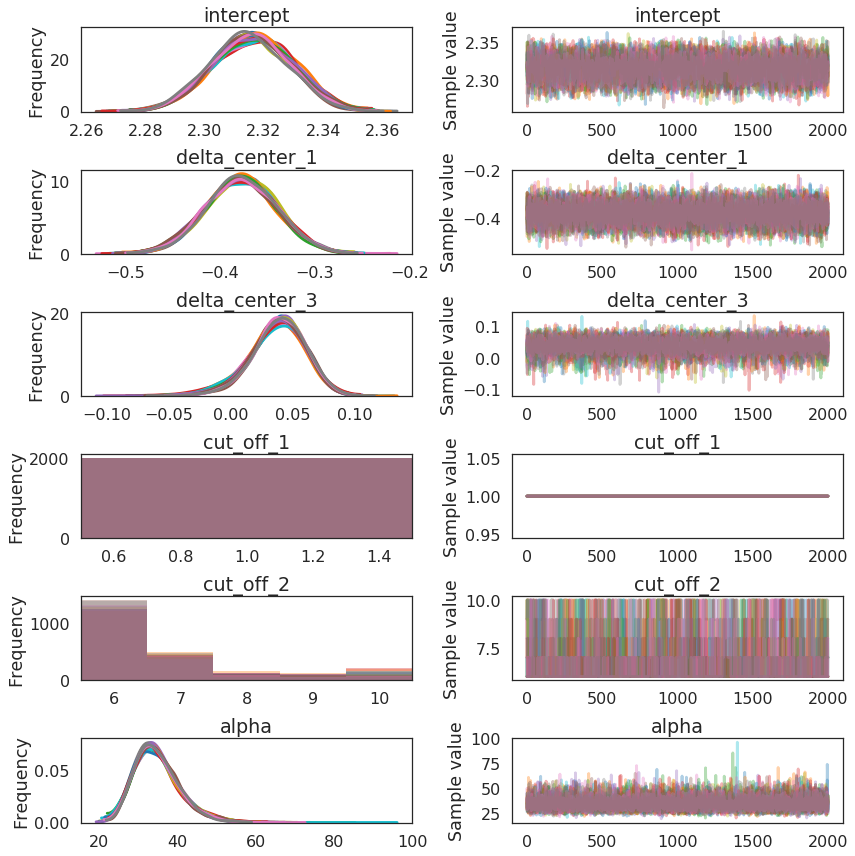

In [264]:
pm.traceplot(model_flat_df.loc[((13095, 'negative_binomial', 'VGLUT1', '5'), 'trace')])

Here, apparently a 3-partite model fits better than a linear gradient
Cut-off 1 is at 1 (so sector 1 consists of 1 "sector" along the first PCA axis), and cut-off 2 is around 6 (with a boundary effect - it's probably aiming for 5 or so). This seems right if we inspect the intensity change across the PCA axis

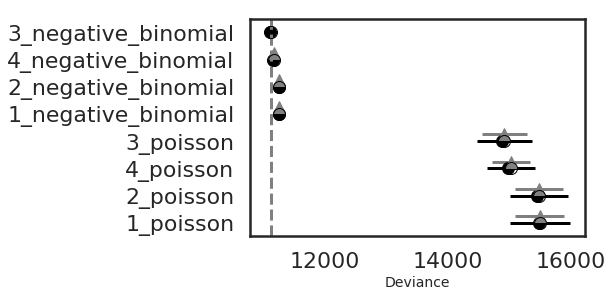

In [376]:
pm.compareplot(compares.loc[(15033, 'MBP')])

In [162]:
visualize_intensity_across_space(df.loc[(df.subject_id==15033) & (df.stain=='MBP')], per_slice=False)
plt.gcf().set_size_inches(3,3)

NameError: name 'visualize_intensity_across_space' is not defined

Given this rather interesting U-shape, no wonder a three-partite model fits better than a line...
Again, we can inspect the hypothesized locations of the cut-offs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d6e920898>,
      dtype=object)

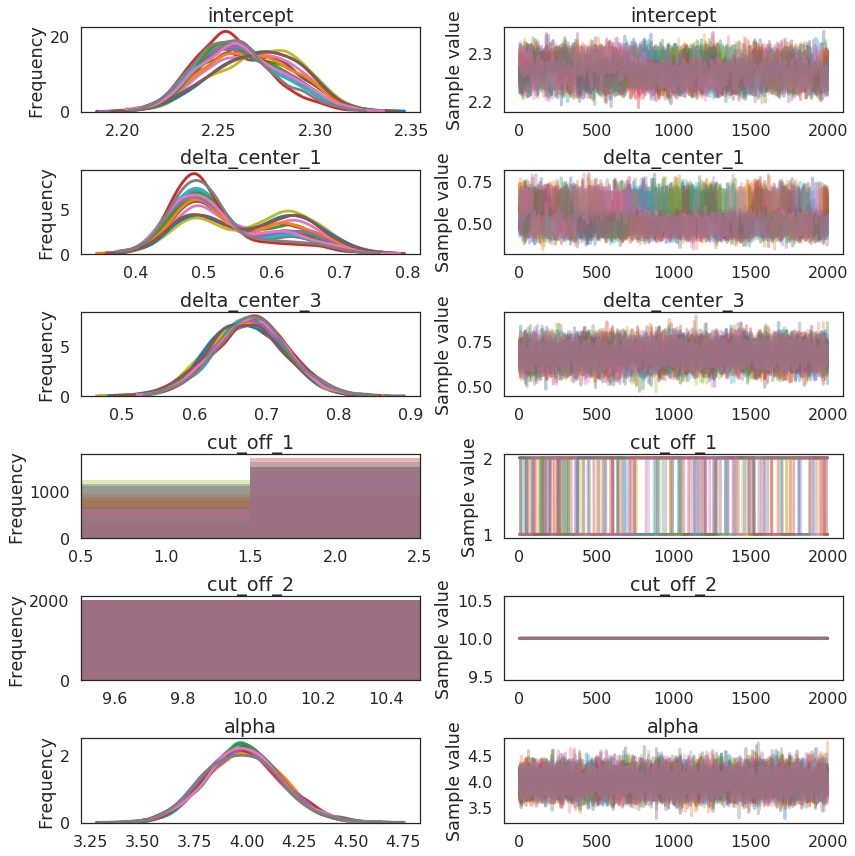

In [265]:
pm.traceplot(model_flat_df.loc[((15033, 'negative_binomial', 'MBP', '5'), 'trace')])

And again, this seems to make sense. Notice however the sampling issues with this model

15055/VGLUT1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d6906efd0>,
      dtype=object)

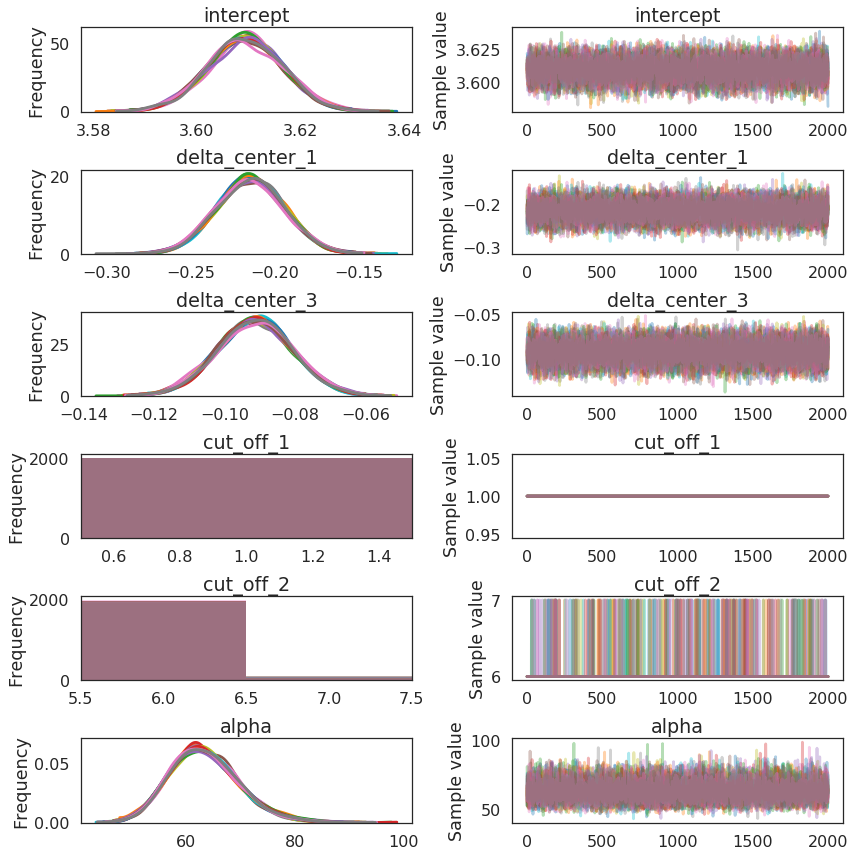

In [267]:
pm.traceplot(model_flat_df.loc[((15055, 'negative_binomial', 'VGLUT1', '5'), 'trace')])

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


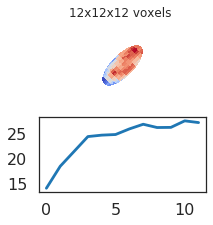

In [283]:
# visualize_intensity_across_space(df.loc[(df.subject_id==15033) & (df.stain=='VGLUT1')], per_slice=False)
# plt.gcf().set_size_inches(3,3)

This all seems to make sense

In [271]:
model_flat_df

model  \
subject_id dist              stain   model_n                                                 
13095      poisson           CALR    1        <pymc3.model.Model object at 0x7f3e12cef550>   
                                     2        <pymc3.model.Model object at 0x7f3e12cef0f0>   
                                     3        <pymc3.model.Model object at 0x7f3e1641cf28>   
                                     4        <pymc3.model.Model object at 0x7f3e146d14e0>   
                                     5        <pymc3.model.Model object at 0x7f3e150d3080>   
                             FER     1        <pymc3.model.Model object at 0x7f3e152f3a20>   
                                     2        <pymc3.model.Model object at 0x7f3e15546470>   
                                     3        <pymc3.model.Model object at 0x7f3e1695b518>   
                                     4        <pymc3.model.Model object at 0x7f3e16531978>   
                                     5        <pymc3.model.Model object at 0x7f3e15c9a400>   
                             GABRA3  1        <pymc3.model.Model object at 0x7f3e15e40cf8>   
                                     2        <pymc3.model.Model object at 0x7f3e1739d2b0>   
                                     3        <pymc3.model.Model object at 0x7f3e172e5a20>   
                                     4        <pymc3.model.Model object at 0x7f3e1bf44f28>   
                                     5        <pymc3.model.Model object at 0x7f3e2ab55048>   
                             GAD6567 1        <pymc3.model.Model object at 0x7f3e251e5780>   
                                     2        <pymc3.model.Model object at 0x7f3e1f102630>   
                                     3        <pymc3.model.Model object at 0x7f3e192023c8>   
                                     4        <pymc3.model.Model object at 0x7f3e1ff70a90>   
                                     5        <pymc3.model.Model object at 0x7f3e210b0630>   
                             MBP     1        <pymc3.model.Model object at 0x7f3e21ae6f60>   
                                     2        <pymc3.model.Model object at 0x7f3e17c7ff98>   
                                     3        <pymc3.model.Model object at 0x7f3e24819f98>   
                                     4        <pymc3.model.Model object at 0x7f3e1bc6a588>   
                                     5        <pymc3.model.Model object at 0x7f3e21f1aba8>   
                             PARV    1        <pymc3.model.Model object at 0x7f3e143dca90>   
                                     2        <pymc3.model.Model object at 0x7f3e18cb7e10>   
                                     3        <pymc3.model.Model object at 0x7f3e128b8f98>   
                                     4        <pymc3.model.Model object at 0x7f3e1acc5278>   
                                     5        <pymc3.model.Model object at 0x7f3e167341d0>   
...                                                                                    ...   
15055      negative_binomial SERT    1        <pymc3.model.Model object at 0x7f3d80ac3550>   
                                     2        <pymc3.model.Model object at 0x7f3d7edf4c50>   
                                     3        <pymc3.model.Model object at 0x7f3d7ede06a0>   
                                     4        <pymc3.model.Model object at 0x7f3d7ecc4978>   
                                     5        <pymc3.model.Model object at 0x7f3d7ddcaa58>   
                             SMI32   1        <pymc3.model.Model object at 0x7f3d7e90bf98>   
                                     2        <pymc3.model.Model object at 0x7f3d7d6a5f98>   
                                     3        <pymc3.model.Model object at 0x7f3d7ddbf588>   
                                     4        <pymc3.model.Model object at 0x7f3d7cb756a0>   
                                     5        <pymc3.model.Model object at 0x7f3d7cef6da0>   
                             SYN     1     

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d57574518>,
      dtype=object)

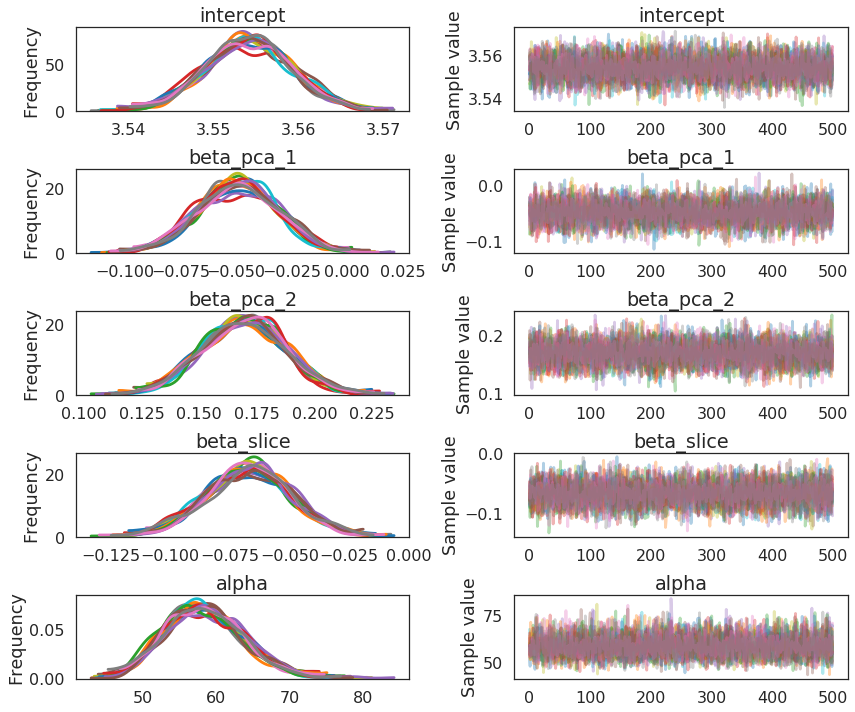

In [285]:
pm.traceplot(model_flat_df.loc[((15055, 'negative_binomial', 'VGLUT1', '4'), 'trace')])

In [287]:
idx

(13095, 'poisson', 'CALR', '4')

##### PPCs
Generate data using the fitted models to see if they resemble the true STNs

In [283]:
def ppc_stn(df, trace, distribution='poisson', model_n=1, n_samples=500):
    
    trace_df = pm.trace_to_dataframe(trace)
    out_array = np.empty((df.shape[0], n_samples))

    for i in np.arange(n_samples):
        if i % 10 == 0:
            print('.', end='')
        random_row = np.random.randint(low=0, high=trace_df.shape[0])
        
        if model_n == 1:
            ev = np.exp(trace_df.iloc[random_row]['intercept'])
        elif model_n == 2:
            ev = np.exp(trace_df.iloc[random_row]['intercept'] + \
                        trace_df.iloc[random_row]['beta_pca_1']*df['pc1_sector_coordinate'].values)
        elif model_n == 3:
            pass
        elif model_n == 4:
            ev = np.exp(trace_df.iloc[random_row]['intercept'] + \
                        trace_df.iloc[random_row]['beta_pca_1']*df['pc1_sector_coordinate'].values + \
                        trace_df.iloc[random_row]['beta_pca_2']*df['pc2_sector_coordinate'].values + \
                        trace_df.iloc[random_row]['beta_slice']*df['slice_sector_coordinate'].values)
            
        elif model_n == 5 or model_n == 6:
            is_sector_2 = (df['pc1_sector_number'].values >= trace_df.iloc[random_row]['cut_off_1']) & (df['pc1_sector_number'].values >= trace_df.iloc[random_row]['cut_off_2'])
            is_sector_1 = df['pc1_sector_number'].values < trace_df.iloc[random_row]['cut_off_1']
            is_sector_3 = df['pc1_sector_number'].values > trace_df.iloc[random_row]['cut_off_2']
#             sector2 = trace_df.iloc[random_row]['intercept']*((df['pc1_sector_number'].values >= trace_df.iloc[random_row]['cut_off_1']) & (df['pc1_sector_number'].values <= trace_df.iloc[random_row]['cut_off_2']))
#             sector1 = trace_df.iloc[random_row]['delta_center_1']*(df['pc1_sector_number'].values < trace_df.iloc[random_row]['cut_off_1'])
#             sector3 = trace_df.iloc[random_row]['delta_center_3']
            ev = np.exp(is_sector_1*trace_df.iloc[random_row]['delta_center_1'] +\
                        is_sector_2*trace_df.iloc[random_row]['intercept'] +\
                        is_sector_3*trace_df.iloc[random_row]['delta_center_3'])
                        
        if distribution == 'poisson':
            out_array[:,i] = ev
        else:
            out_array[:,i] = ev  # do something with variance as well?
    return out_array

In [279]:
df.stain.unique()

array(['CALR', 'FER', 'GABRA3', 'GAD6567', 'MBP', 'PARV', 'SERT', 'SMI32',
       'SYN', 'TH', 'TRANSF', 'VGLUT1'], dtype=object)

In [280]:
subj_id = 13095
stain = 'FER'
model_n = 5
data_df_idx = (df.subject_id==subj_id) & (df.stain==stain)
model_df_idx = (subj_id, 'poisson', stain, str(model_n))

ppc = ppc_stn(df=df.loc[data_df_idx], trace=model_flat_df.loc[(model_df_idx, 'trace')], model_n=model_n, n_samples=500)

..................................................

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6342a5edd8>,
      dtype=object)

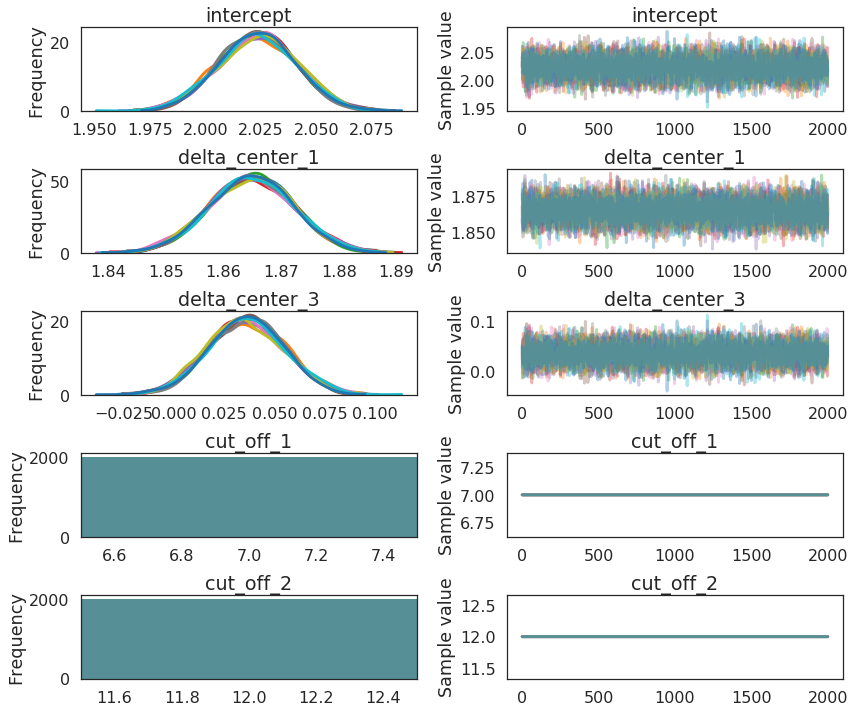

In [284]:
pm.traceplot(model_flat_df.loc[(model_df_idx, 'trace')])

In [285]:
ppc_mean = ppc.mean(axis=1)
df_tmp = df.loc[data_df_idx].copy()
df_tmp['y_predicted'] = ppc_mean

In [286]:
if model_n == 4:
    by_slice = True
else:
    by_slice = False

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


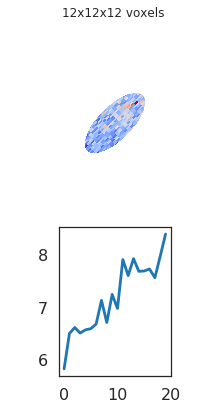

In [287]:
visualize_intensity_across_space(df_tmp, dependent_var='rate', per_slice=False)

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


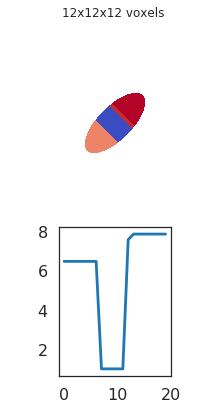

In [288]:
visualize_intensity_across_space(df_tmp, dependent_var='y_predicted', per_slice=False)

In [256]:
np.exp(-1000)

0.0

The distribution seems to fit well

### Hierarchical models

I did some attempts at fitting an hierarchical model but can't get sampling to work well

In [111]:
def get_single_stain_data(df, stain):
    return df.loc[df.stain==stain].copy()

In [113]:
# make output dataframes
import pandas as pd

models = ['1', '2', '3', '4']
stains = df.stain.unique()
distributions = ['negative_binomial', 'poisson']
model_df = pd.DataFrame(columns=stains, index=pd.MultiIndex.from_product([models, distributions], names=['model_n', 'dist']))
traces_df = model_df.copy()

In [207]:
## hierarchical
### Model definitions
from collections import OrderedDict
import pymc3 as pm

for dist in distributions:#, 'log']:
    for stain in df.stain.unique():
        print('.', end='')
        data_stain = get_single_stain_data(df, stain)
        
        for model_n in [1,2,3,4]:
            with pm.Model() as model:
                # Assume mu is gamma-distributed (?)
                alpha = pm.Gamma('pop_alpha', .01, .01)
                beta = pm.Gamma('pop_beta', .01, .01)

                intercept = pm.Gamma('mu_intercept', alpha, beta, shape=len(data_stain.subject_id.unique()))

                if model_n == 1:
                    # Expected value
                    y_est = intercept[data_stain.subject_id_2.values]
                    
                elif model_n == 2:
                    mu_beta_pca_1 = pm.Normal('mu_pca_1_intercept', mu=0, sd=2)
                    sigma_beta_pca_1 = pm.HalfCauchy('sigma_beta_pca_1', beta=1)

                    beta_pca_1_offset = pm.Normal('beta_pca_1_offset', mu=mu_beta_pca_1, sd=sigma_beta_pca_1, 
                                                  shape=len(data_stain.subject_id.unique()))
                    beta_pca_1 = pm.Deterministic('beta_pca_1', mu_beta_pca_1 + beta_pca_1_offset*sigma_beta_pca_1)

                    y_est = intercept[data_stain.subject_id_2.values] * \  #
                            np.exp(beta_pca_1[data_stain.subject_id_2.values]*data_stain['pc1_sector_coordinate'].values)

                elif model_n == 3:
                    mu_delta_center_1 = pm.Normal('mu_delta_center_1', mu=0, sd=2)
                    sigma_delta_center_1 = pm.HalfCauchy('sigma_delta_center_1', beta=2)

                    mu_delta_center_3 = pm.Normal('mu_delta_center_3', mu=0, sd=2)
                    sigma_delta_center_3 = pm.HalfCauchy('sigma_delta_center_3', beta=2)

                    # non-centered specification of individual params
                    dummy_center_1_offset = pm.Normal('dummy_center_1_offset', mu=mu_delta_center_1, sd=sigma_delta_center_1, shape=len(data_stain.subject_id.unique()))
                    dummy_center_1 = pm.Deterministic('dummy_center_1', mu_delta_center_1 + dummy_center_1_offset*sigma_delta_center_1)

                    dummy_center_3_offset = pm.Normal('dummy_center_3_offset', mu=mu_delta_center_3, sd=sigma_delta_center_3, shape=len(data_stain.subject_id.unique()))
                    dummy_center_3 = pm.Deterministic('dummy_center_3', mu_delta_center_3 + dummy_center_3_offset*sigma_delta_center_3)
                    
                    y_est = intercept[data_stain.subject_id_2.values] * \
                            (np.exp(dummy_center_1[data_stain.subject_id_2.values]*(data_stain['x_tripartite_axis_1']==1).astype(int))) * \
                            (np.exp(dummy_center_3[data_stain.subject_id_2.values]*(data_stain['x_tripartite_axis_1']==3).astype(int)))
                
                elif model_n == 4:
                    mu_beta_pca_1 = pm.Normal('mu_pca_1_intercept', mu=0, sd=2)
                    sigma_beta_pca_1 = pm.HalfCauchy('sigma_beta_pca_1', beta=2)

                    mu_beta_pca_2 = pm.Normal('mu_pca_2_intercept', mu=0, sd=2)
                    sigma_beta_pca_2 = pm.HalfCauchy('sigma_beta_pca_2', beta=2)

                    mu_beta_pca_3 = pm.Normal('mu_pca_3_intercept', mu=0, sd=2)
                    sigma_beta_pca_3 = pm.HalfCauchy('sigma_beta_pca_3', beta=2)

                    beta_pca_1_offset = pm.Normal('beta_pca_1_offset', mu=mu_beta_pca_1, sd=sigma_beta_pca_1, shape=len(data_stain.subject_id.unique()))
                    beta_pca_1 = pm.Deterministic('beta_pca_1', mu_beta_pca_1 + beta_pca_1_offset*sigma_beta_pca_1)

                    beta_pca_2_offset = pm.Normal('beta_pca_2_offset', mu=mu_beta_pca_2, sd=sigma_beta_pca_2, shape=len(data_stain.subject_id.unique()))
                    beta_pca_2 = pm.Deterministic('beta_pca_2', mu_beta_pca_2 + beta_pca_2_offset*sigma_beta_pca_2)

                    beta_pca_3_offset = pm.Normal('beta_pca_3_offset', mu=mu_beta_pca_3, sd=sigma_beta_pca_3, shape=len(data_stain.subject_id.unique()))
                    beta_pca_3 = pm.Deterministic('beta_pca_3', mu_beta_pca_3 + beta_pca_3_offset*sigma_beta_pca_3)

                    # Expected value
                    y_est = intercept[data_stain.subject_id_2.values] * \
                            np.exp(beta_pca_1[data_stain.subject_id_2.values]*data_stain['pc1_sector_coordinate']) + \
                            np.exp(beta_pca_2[data_stain.subject_id_2.values]*data_stain['pc2_sector_coordinate']) + \
                            np.exp(beta_pca_3[data_stain.subject_id_2.values]*data_stain['slice_sector_coordinate'])
                
                # likelihood is the same for all models - except that y_est changes
                if dist == 'poisson':
                    likelihood = pm.Poisson('y', mu=y_est, observed=data_stain['y'])
                elif dist == 'negative_binomial':
                    alpha = pm.HalfCauchy('alpha', beta=10)
                    likelihood = pm.NegativeBinomial('y', mu=y_est, alpha=alpha, observed=data_stain['y'])
            
            model.name = str(model_n) + '_' + dist
            model_df.loc[((str(model_n), dist), stain)] = model

model_df.head()

..

CALR  FER  \
model_n dist                                                                   
1       negative_binomial  <pymc3.model.Model object at 0x7f0c4f93cba8>  NaN   
        poisson            <pymc3.model.Model object at 0x7f0c438d8eb8>  NaN   
2       negative_binomial  <pymc3.model.Model object at 0x7f0c4e925128>  NaN   
        poisson            <pymc3.model.Model object at 0x7f0c433c6dd8>  NaN   
3       negative_binomial  <pymc3.model.Model object at 0x7f0c52fe34e0>  NaN   

                          GABRA3 GAD6567  MBP PARV SERT SMI32  SYN   TH  \
model_n dist                                                              
1       negative_binomial    NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   
        poisson              NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   
2       negative_binomial    NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   
        poisson              NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   
3       negative_binomial    NaN     NaN  NaN  NaN  NaN   NaN  NaN  NaN   

                          TRANSF VGLUT1  
model_n dist                             
1       negative_binomial    NaN    NaN  
        poisson              NaN    NaN  
2       negative_binomial    NaN    NaN  
        poisson              NaN    NaN  
3       negative_binomial    NaN    NaN

In [208]:
stains_to_run = df.stain.unique()
models_to_run = [4, 3, 2, 1]  #,3,4]
dists = ['negative_binomial']  #poisson']
overwrite = True

for stain in stains_to_run:
    for model_n in models_to_run:
        for dist in dists:
            
            print('running stain {}, model {}, {} distribution'.format(stain, str(model_n), dist))
            if pd.notnull(traces_df.loc[(str(model_n), dist), stain]) and not overwrite:
                print('Already ran, skipping...')
                # already run?
                continue
            
            this_model = model_df.loc[(str(model_n), dist), stain]
            trace = pm.sample(model=this_model, cores=18, target_accept=.9, tune=1000)
            traces_df.loc[(str(model_n), dist), stain] = trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/mkeuken1/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.8-64/lock_dir/lock


running stain CALR, model 4, negative_binomial distribution


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, eps, beta_pca_3_offset, beta_pca_2_offset, beta_pca_1_offset, sigma_beta_pca_3, mu_pca_3_intercept, sigma_beta_pca_2, mu_pca_2_intercept, sigma_beta_pca_1, mu_pca_1_intercept, mu_intercept, pop_beta, pop_alpha]
Sampling 2 chains:  40%|████      | 802/2000 [05:54<08:49,  2.26draws/s]


ValueError: Not enough samples to build a trace.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c7bd045f8>,
      dtype=object)

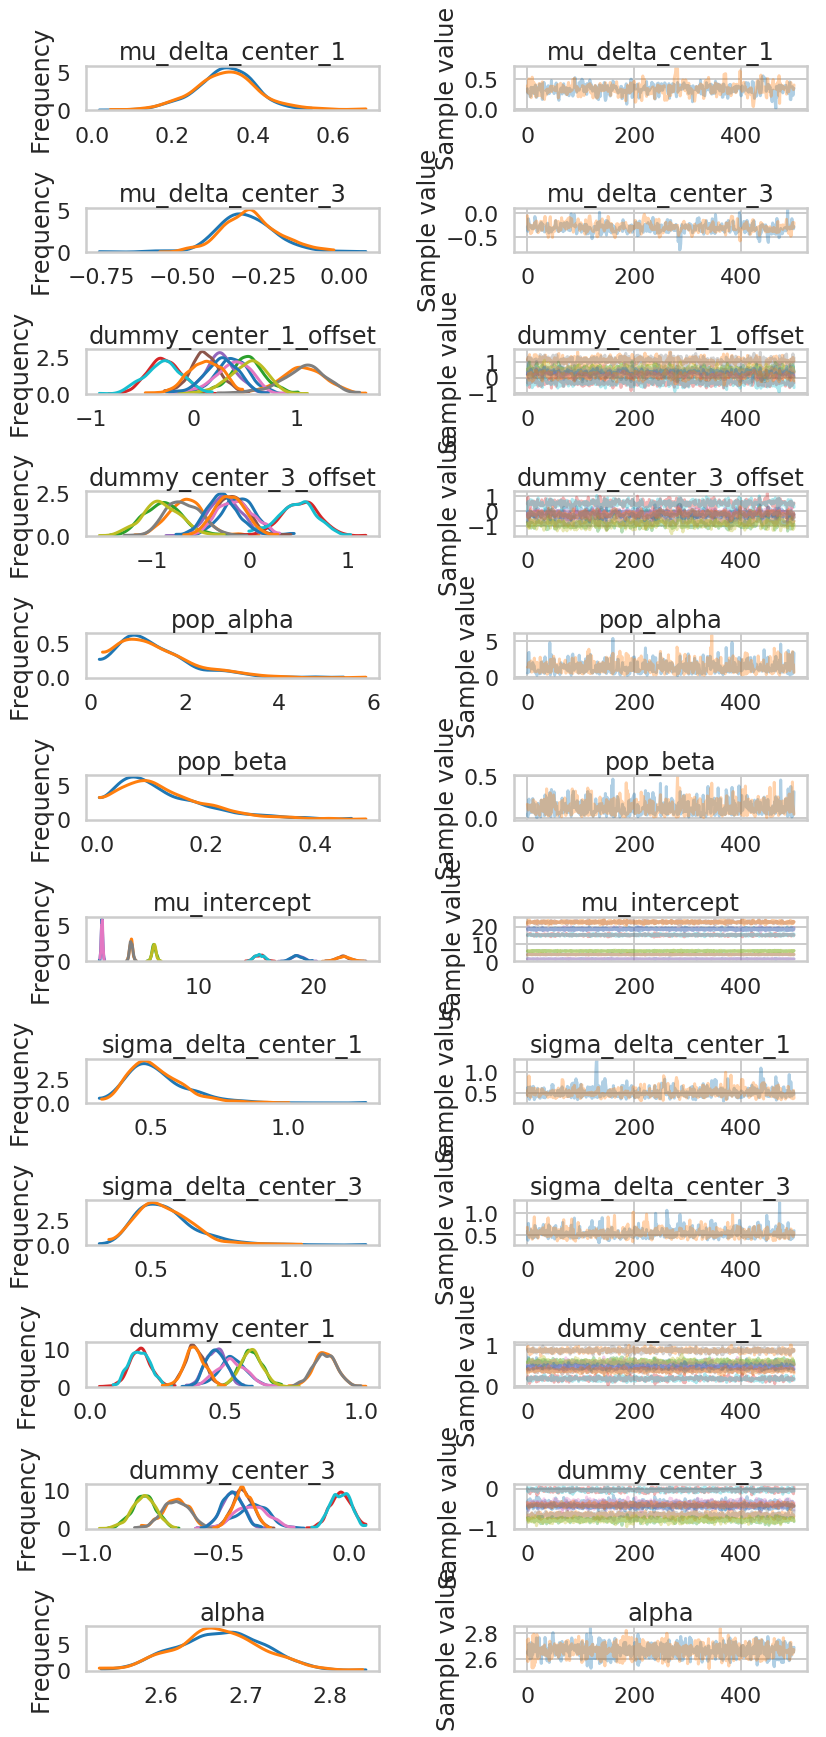

In [199]:
pm.traceplot(traces_df.loc[(('3', 'negative_binomial'), 'CALR')])

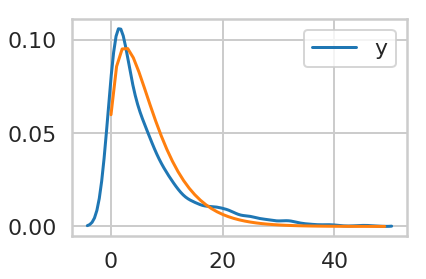

In [175]:
sns.kdeplot(data_stain.loc[data_stain.subject_id_2==2, 'y'])
plt.plot(np.arange(50), NegBinom(x=np.arange(50), m=6.725157, a=1.819402))

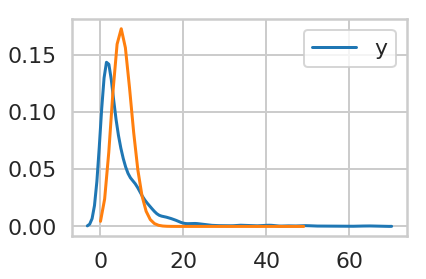

In [139]:
sns.kdeplot(data_stain.loc[data_stain.subject_id_2==1, 'y'])
plt.plot(np.arange(50), sp.stats.poisson.pmf(np.arange(50), 5.424135))

In [185]:
pm.summary(traces_df.loc[(('2', 'negative_binomial'), 'CALR')])

mean        sd  mc_error    hpd_2.5   hpd_97.5  \
mu_pca_1_intercept    -2.063537  0.457158  0.022555  -2.920911  -1.119965   
beta_pca_1_offset__0  -0.137709  0.286486  0.012399  -0.658022   0.481449   
beta_pca_1_offset__1  -2.460064  0.344512  0.016230  -3.108396  -1.818203   
beta_pca_1_offset__2  -2.421623  0.341354  0.015927  -3.013655  -1.718618   
beta_pca_1_offset__3  -1.116161  0.330490  0.013747  -1.726183  -0.435636   
beta_pca_1_offset__4  -3.472154  0.472157  0.022562  -4.319742  -2.446254   
beta_pca_1_offset__5  -3.450890  0.464942  0.022206  -4.248645  -2.462201   
pop_alpha              0.949930  0.471038  0.017618   0.126206   1.796496   
pop_beta               0.102983  0.065083  0.002398   0.000897   0.218122   
mu_intercept__0        0.618748  0.037836  0.001101   0.535968   0.686338   
mu_intercept__1        2.366468  0.073117  0.002013   2.231514   2.503279   
mu_intercept__2        3.685110  0.096544  0.002993   3.490283   3.859325   
mu_intercept__3       14.452247  0.290863  0.009631  13.854041  14.999537   
mu_intercept__4       14.912142  0.292444  0.007634  14.342104  15.504576   
mu_intercept__5       18.551192  0.354775  0.011231  17.744024  19.197920   
sigma_beta_pca_1       1.505693  0.274046  0.014616   1.080904   2.105506   
beta_pca_1__0         -2.307138  0.115804  0.003598  -2.527304  -2.079771   
beta_pca_1__1         -5.703141  0.111169  0.003652  -5.905369  -5.470763   
beta_pca_1__2         -5.647621  0.125509  0.003370  -5.893346  -5.413536   
beta_pca_1__3         -3.729731  0.382343  0.012287  -4.385521  -2.889327   
beta_pca_1__4         -7.185343  0.162314  0.004922  -7.479888  -6.834044   
beta_pca_1__5         -7.156041  0.168450  0.004801  -7.470918  -6.833537   
alpha                  2.667422  0.050812  0.001483   2.564212   2.761718   

                            n_eff      Rhat  
mu_pca_1_intercept     398.512090  1.001906  
beta_pca_1_offset__0   512.241146  1.001266  
beta_pca_1_offset__1   341.735990  1.001265  
beta_pca_1_offset__2   351.413250  1.003168  
beta_pca_1_offset__3   566.046744  1.000473  
beta_pca_1_offset__4   341.961952  1.000858  
beta_pca_1_offset__5   331.877917  1.000575  
pop_alpha              760.266622  0.999413  
pop_beta               751.633591  0.999024  
mu_intercept__0       1208.855354  1.000311  
mu_intercept__1       1185.576038  0.999316  
mu_intercept__2       1032.135461  0.999751  
mu_intercept__3        973.505639  0.999253  
mu_intercept__4       1465.745494  0.999786  
mu_intercept__5       1084.945865  0.999566  
sigma_beta_pca_1       300.929770  0.999401  
beta_pca_1__0         1088.140078  0.999173  
beta_pca_1__1          975.924503  0.999533  
beta_pca_1__2         1138.899548  1.000119  
beta_pca_1__3          970.231210  0.999147  
beta_pca_1__4         1049.642796  0.999055  
beta_pca_1__5         1097.482037  0.999099  
alpha                 1315.718106  1.001587

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c7ab2ae80>,
      dtype=object)

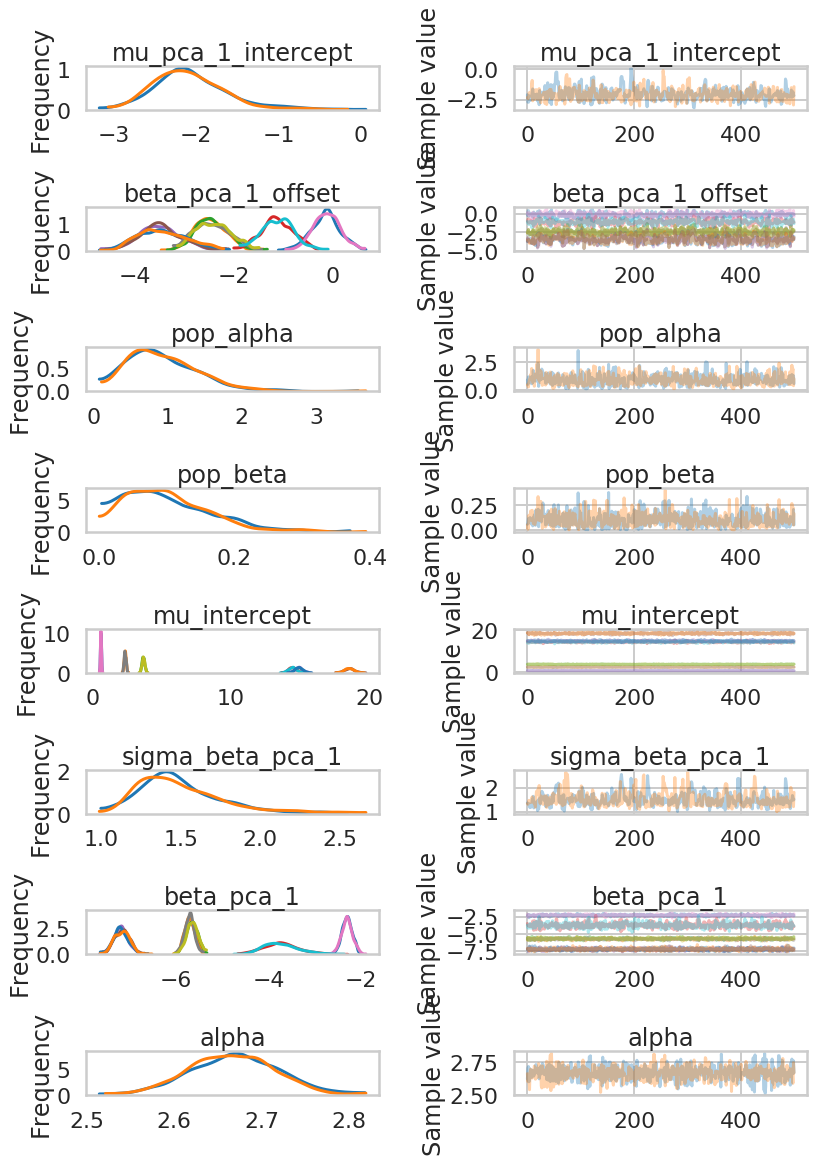

In [187]:
pm.traceplot(traces_df.loc[(('2', 'negative_binomial'), 'CALR')])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bcde25978>,
      dtype=object)

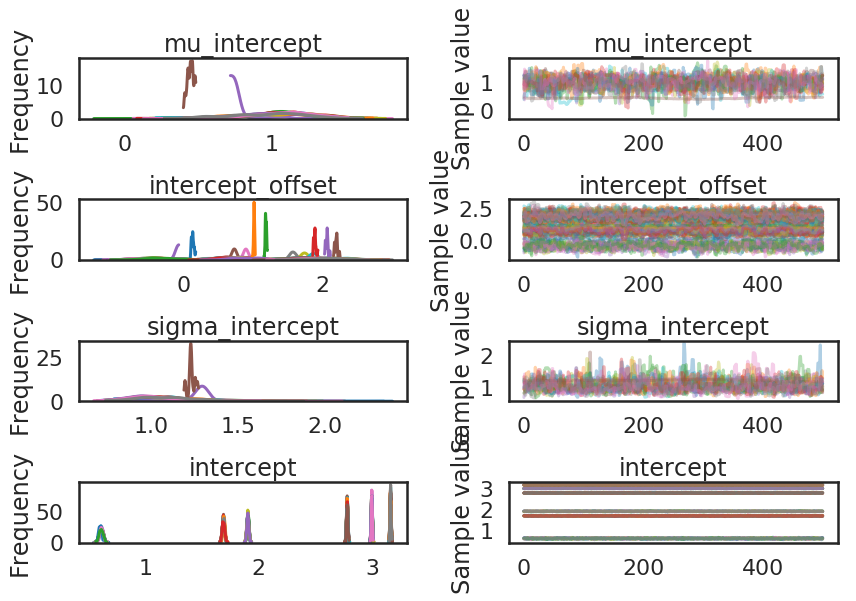

In [281]:
pm.traceplot(trace)

In [390]:
df.groupby(['subject_id', 'stain']).value.min()

subject_id  stain  
13095       CALR       5.401682e-08
            FER        1.493662e+00
            GABRA3     1.789251e-01
            GAD6567    7.217613e-06
            MBP        1.572817e-01
            PARV       6.335640e-02
            SERT       3.605445e-01
            SMI32      2.421312e-01
            SYN        9.014705e-01
            TH         0.000000e+00
            TRANSF     1.513548e+00
            VGLUT1     9.184465e-01
14037       CALR       1.586169e-03
            FER        5.228443e+00
            GABRA3     1.829381e+00
            GAD6567    5.373947e-01
            MBP        6.521627e-01
            PARV       2.807160e-01
            SERT       1.851284e-01
            SMI32      6.095462e+00
            SYN        1.736851e+00
            TH         2.046098e-06
            TRANSF     5.476191e+00
            VGLUT1     7.800327e+00
14051       CALR       5.010041e-03
            FER        4.084007e+00
            GABRA3     1.770330e-04
        

In [386]:
df['value_log'].min()

-inf

In [387]:
sns.kd2plot(df['value_log'])

AttributeError: module 'seaborn' has no attribute 'kd2plot'

In [281]:
traces_df

CALR  FER GABRA3  \
model_n value                                                                  
1       raw    ({'intercept_offset': [0.014111253562102744, 0...  NaN    NaN   
        log    ({'intercept_offset': [-0.0023900833573425387,...  NaN    NaN   
2       raw    ({'mu_intercept': 0.005210482811349724, 'sigma...  NaN    NaN   
        log    ({'mu_intercept': -0.005920638490296717, 'sigm...  NaN    NaN   
3       raw    ({'mu_intercept': -0.07102119472253483, 'sigma...  NaN    NaN   
        log                                                  NaN  NaN    NaN   
4       raw                                                  NaN  NaN    NaN   
        log                                                  NaN  NaN    NaN   

              GAD6567  MBP PARV SERT SMI32  SYN   TH TRANSF VGLUT1  
model_n value                                                       
1       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
2       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
3       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
4       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN

In [282]:
traces_df[stain]

model_n  value
1        raw      ({'intercept_offset': [0.014111253562102744, 0...
         log      ({'intercept_offset': [-0.0023900833573425387,...
2        raw      ({'mu_intercept': 0.005210482811349724, 'sigma...
         log      ({'mu_intercept': -0.005920638490296717, 'sigm...
3        raw      ({'mu_intercept': -0.07102119472253483, 'sigma...
         log                                                    NaN
4        raw                                                    NaN
         log                                                    NaN
Name: CALR, dtype: object

In [287]:
traces_df[]

CALR  FER GABRA3  \
model_n value                                                                  
1       raw    ({'intercept_offset': [0.014111253562102744, 0...  NaN    NaN   
        log    ({'intercept_offset': [-0.0023900833573425387,...  NaN    NaN   
2       raw    ({'mu_intercept': 0.005210482811349724, 'sigma...  NaN    NaN   
        log    ({'mu_intercept': -0.005920638490296717, 'sigm...  NaN    NaN   
3       raw    ({'mu_intercept': -0.07102119472253483, 'sigma...  NaN    NaN   
        log                                                  NaN  NaN    NaN   
4       raw                                                  NaN  NaN    NaN   
        log                                                  NaN  NaN    NaN   

              GAD6567  MBP PARV SERT SMI32  SYN   TH TRANSF VGLUT1  
model_n value                                                       
1       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
2       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
3       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
4       raw       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN  
        log       NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN    NaN

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4d37539e8>,
      dtype=object)

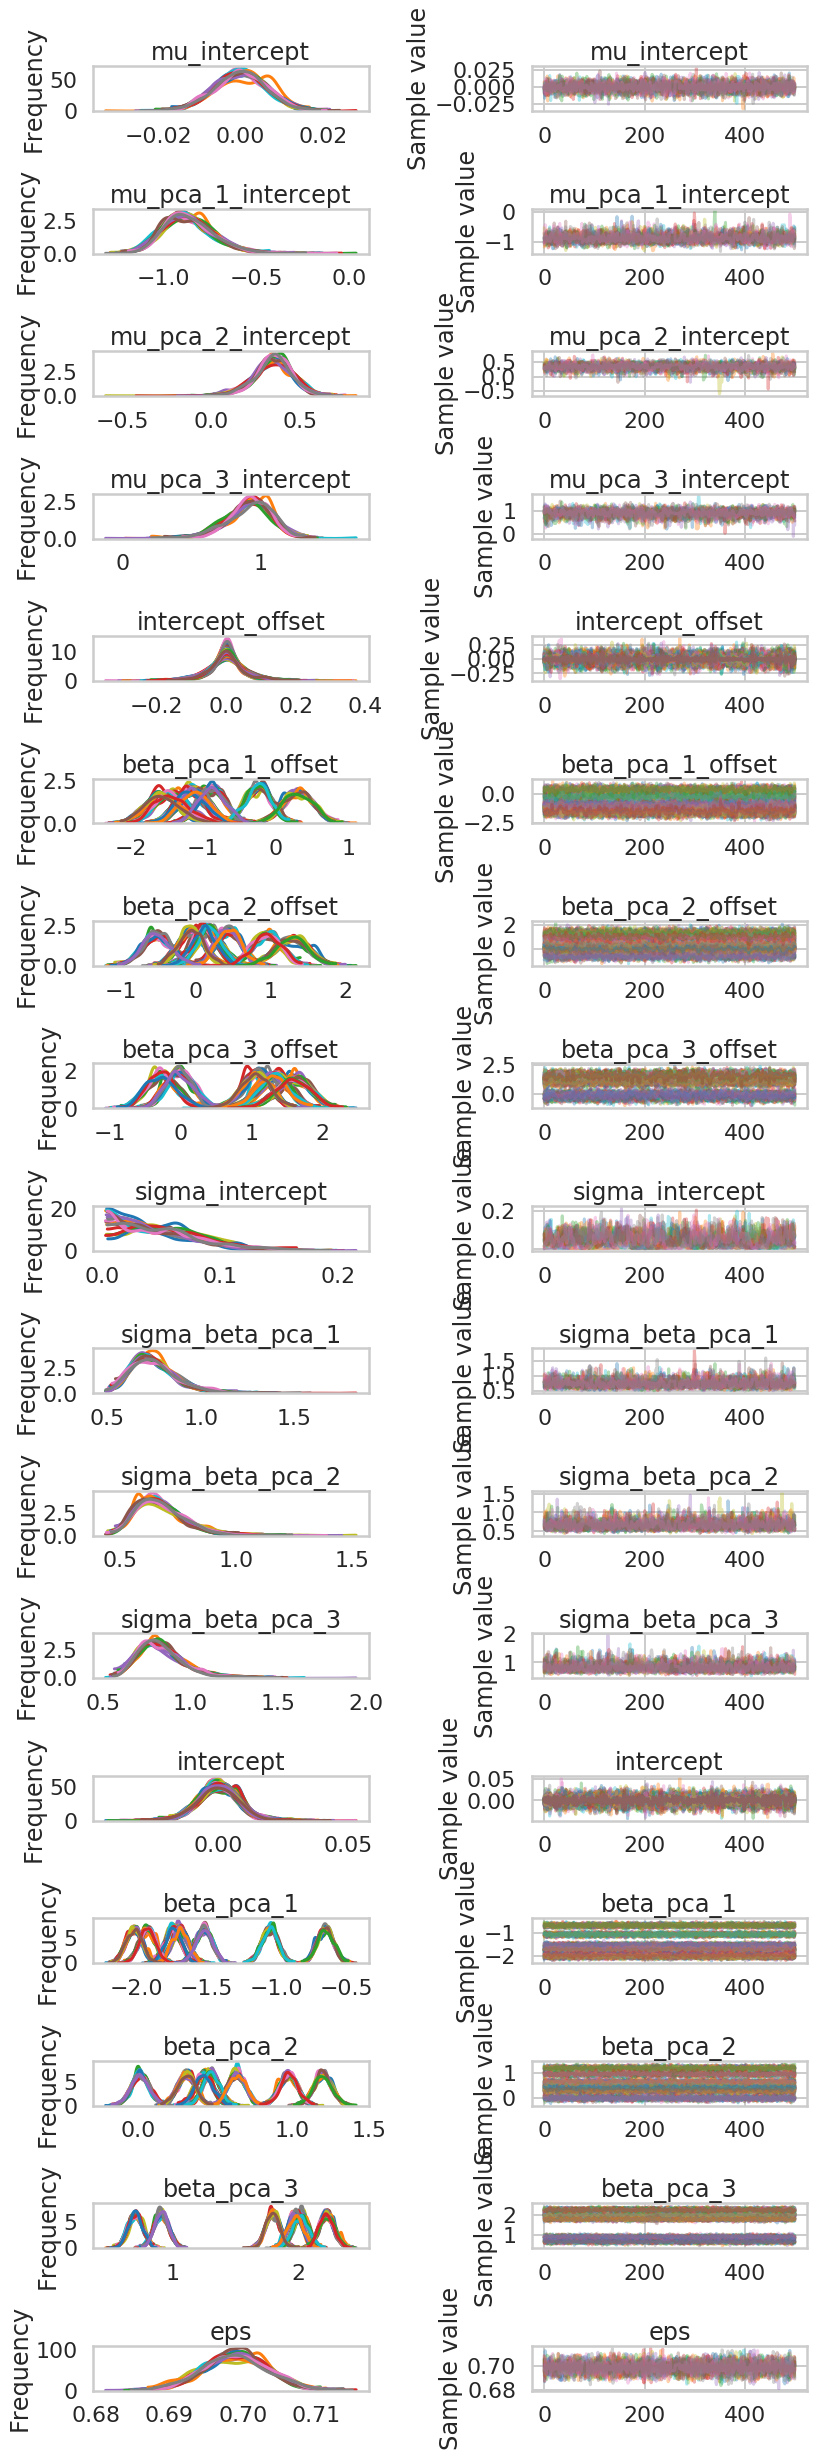

In [310]:
pm.traceplot(traces_df.loc[(('4', 'raw'), 'CALR')])

In [294]:
stain = 'CALR'
waic_comp = pm.compare(dict(zip(model_df[pd.notnull(traces_df[stain])][stain], traces_df[pd.notnull(traces_df[stain])][stain])))

/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

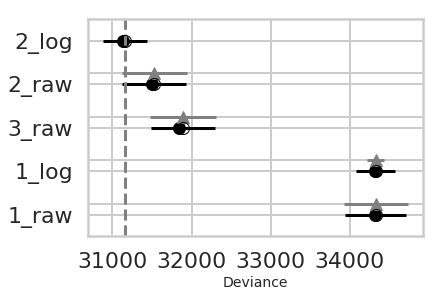

In [295]:
pm.compareplot(waic_comp)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5269c6fd0>,
      dtype=object)

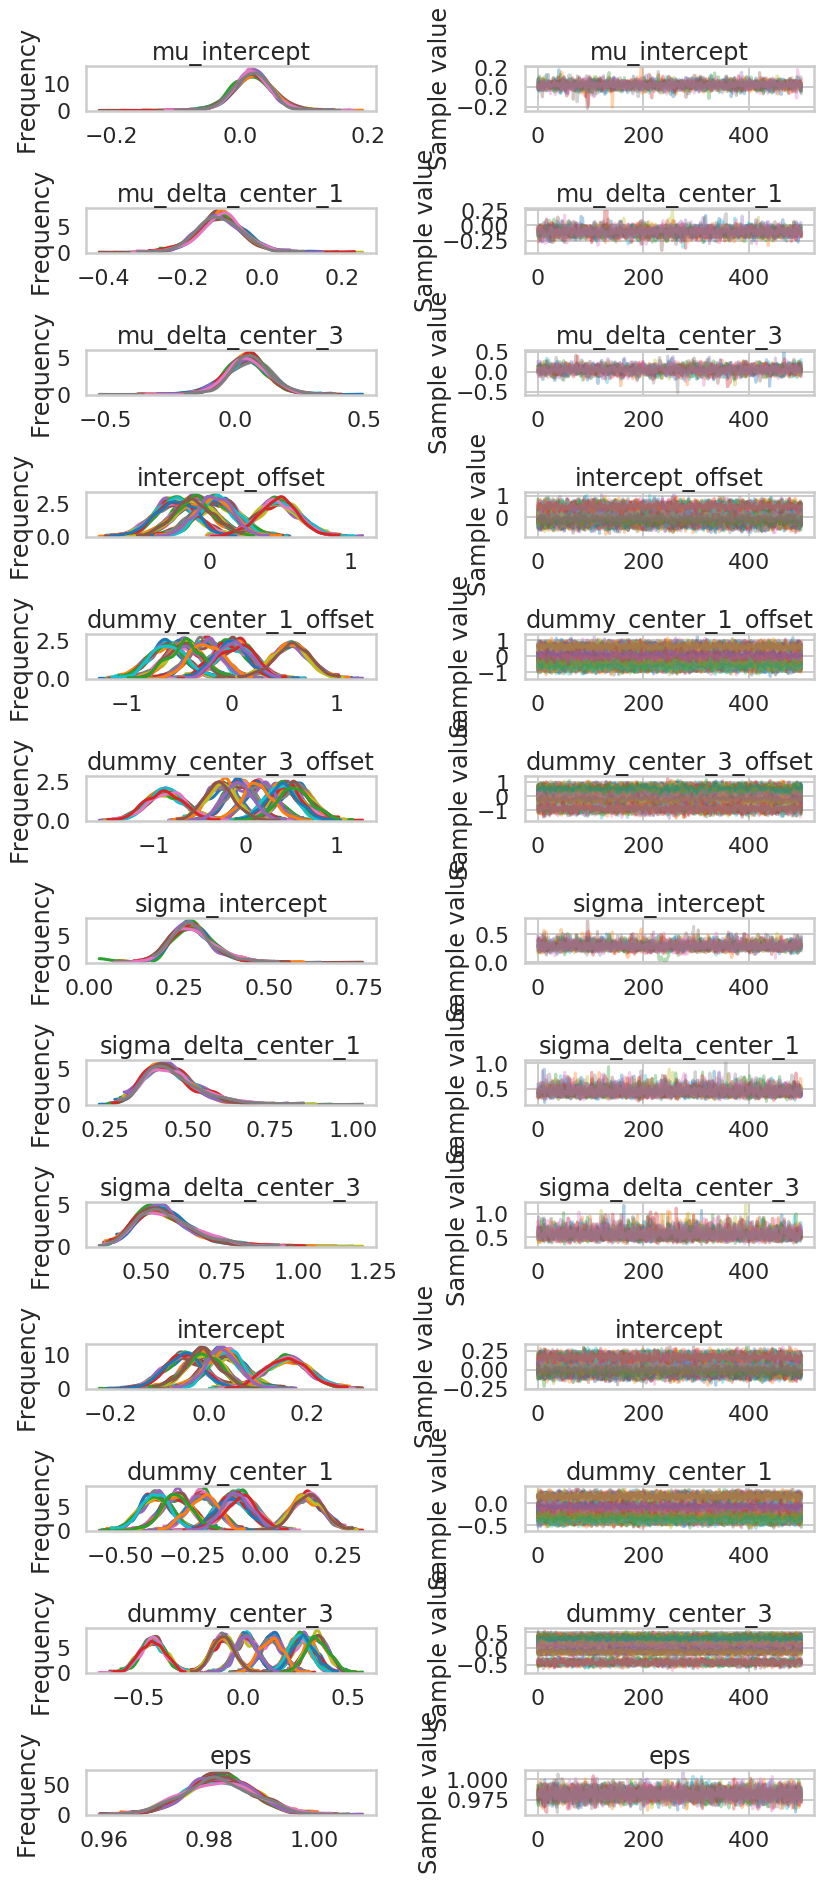

In [259]:

traceplot(traces_df.loc[(('3', 'log'), 'FER')])

/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
      

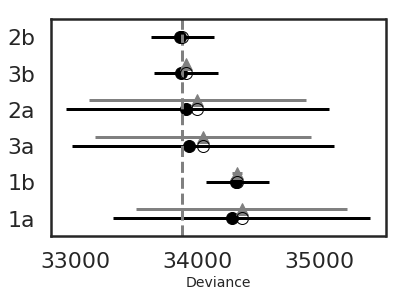

In [118]:
# model comparison
comp_loo = pm.compare(model_traces, ic='LOO')
pm.compareplot(comp_loo)


/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/opt/anaconda/anaconda2/envs/python3/lib

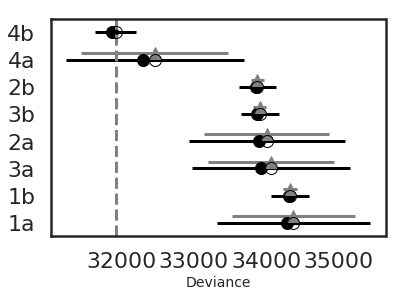

In [125]:
# model comparison
comp_waic = pm.compare(model_traces)
pm.compareplot(comp_waic)

In [127]:
comp_waic

WAIC  pWAIC    dWAIC weight       SE      dSE var_warn
4b  31922.6  25.65        0    0.1   285.16        0        1
4a  32461.1   80.6   538.53   0.89  1227.11  1012.91        1
2b  33877.4  10.98  1954.87   0.01   256.18    89.06        1
3b    33908  22.01  1985.39      0   259.77    90.11        1
2a  34003.2  54.46  2080.61      0  1076.48   866.06        1
3a    34063  66.17  2140.43      0  1085.38   875.24        1
1b  34327.1   4.48  2404.53   0.01   257.04   100.15        1
1a  34373.7  45.07  2451.09      0   1060.4   850.77        1

In [214]:
traceplot(list(model_traces.items())[6][1])

NameError: name 'traceplot' is not defined

In [59]:
traceplot(model_traces[])

KeyError: 6

## Some simple clustering attempts

This was an earlier idea that came to my mind, but doesn't really seem to work

In [ ]:
mid_slice = df.y_mm.unique()[df.y_mm.unique().shape[0]/2]a

In [ ]:
df_to_plot = df.loc[df.y_mm==mid_slice]

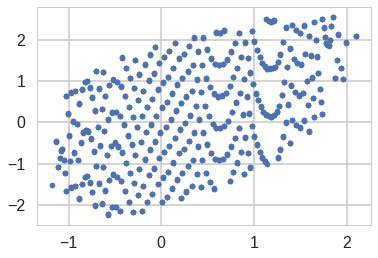

In [5]:
import pandas as pd
import matplotlib.cm as cm
%matplotlib inline
colors = cm.rainbow(df_to_plot.value.values)
colors = np.round(colors, 3)
idx = np.linspace(0, df_to_plot.shape[0]-1, 1000).astype(int)

plt.plot(df_to_plot.x_mm.values[idx], df_to_plot.z_mm.values[idx], '.') #list(map(tuple, colors[idx,:])))

In [6]:
df_singlesub = df_to_plot.copy()
df_singlesub = df_singlesub.loc[df_singlesub.subject_id==13095]

df_tmp = df_singlesub.loc[df_singlesub.index.repeat(df_singlesub.value.apply(lambda x: int(x) if pd.notnull(x) else 0))]

In [7]:
df_tmp.head()

fwhm  subject_id      x_mm     y_mm      z_mm stain     value
178961  0.15       13095 -1.180463 -0.33515 -1.232499  CALR  1.246892
178962  0.15       13095 -1.180463 -0.33515 -1.218407  CALR  1.452741
178963  0.15       13095 -1.180463 -0.33515 -1.133856  CALR  3.742728
178963  0.15       13095 -1.180463 -0.33515 -1.133856  CALR  3.742728
178963  0.15       13095 -1.180463 -0.33515 -1.133856  CALR  3.742728

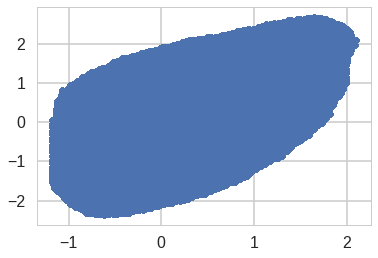

In [8]:
plt.plot(df_tmp.x_mm, df_tmp.z_mm, '.')

In [10]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

models = []
for n_clusters in [1,2,3,4,5,6]:
    gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    gmm.fit(df_tmp[['x_mm', 'z_mm']])
    models.append(gmm)

# Z = -gmm_1cl.score_samples(XX)
# Z = Z.reshape(X.shape)

# CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                  levels=np.logspace(0, 3, 10))
# CB = plt.colorbar(CS, shrink=0.8, extend='both')
# plt.scatter(df_tmp[['x_mm']], df_tmp[['z_mm']], .01)
# plt.show()


In [11]:
x = np.linspace(-2., 2.)
y = np.linspace(-2., 2.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Zs = []
for model in models:
    Z = -model.score_samples(XX)
    Z = Z.reshape(X.shape)
    Zs.append(Z)

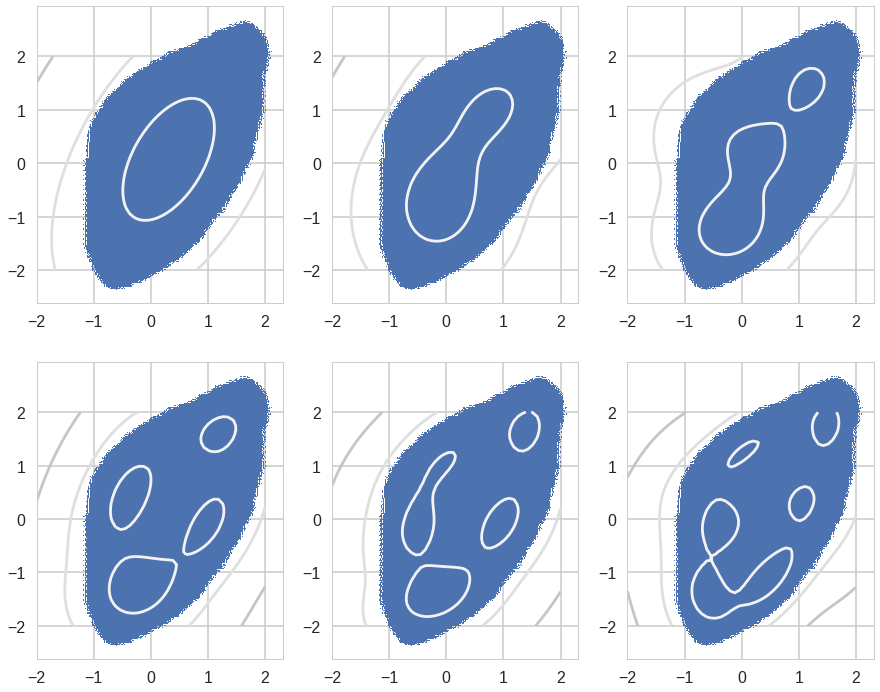

In [16]:
from matplotlib.colors import LogNorm

f, ax = plt.subplots(2,3)
axes = ax.ravel()
for i, Z in enumerate(Zs):
    CS = axes[i].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
#     CB = plt.colorbar(CS, shrink=0.8, extend='both')
    axes[i].scatter(df_tmp[['x_mm']], df_tmp[['z_mm']], .01)
#axes = axes.reshape((2,3))
f.set_size_inches(15, 12)
f.show()

In [ ]:
from matplotlib.colors import LogNorm

f, ax = plt.subplots(2,3)
axes = ax.ravel()
for i, Z in enumerate(Zs):
    CS = axes[i].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
#     CB = plt.colorbar(CS, shrink=0.8, extend='both')
    axes[i].scatter(df_tmp[['x_mm']], df_tmp[['z_mm']], .01)
#axes = axes.reshape((2,3))
f.set_size_inches(15, 12)
f.show()



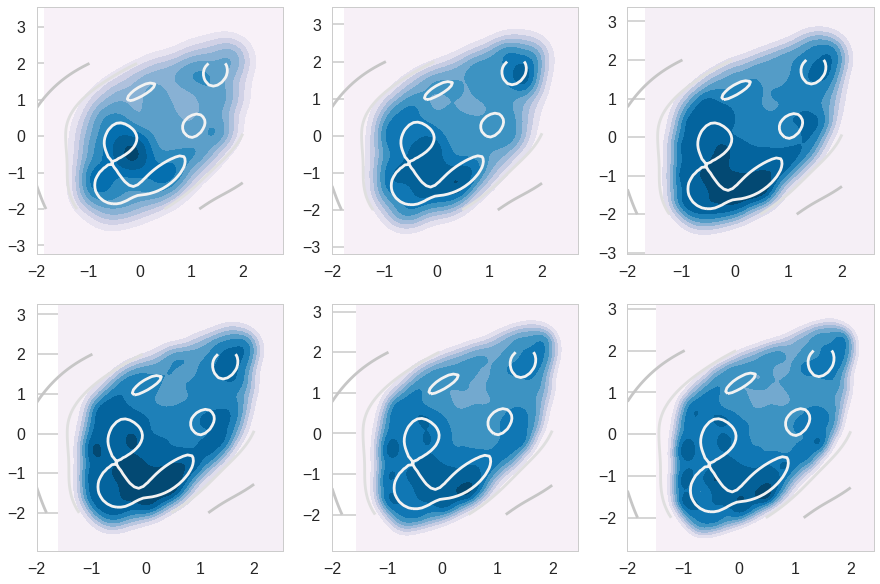

In [45]:
f, ax = plt.subplots(2,3)
axes = ax.ravel()
for i, n_vox in enumerate([1e3, 2e3, 5e3, 1e4, 2e4, 5e4]):
    idx = np.linspace(0, df_tmp.shape[0]-1, n_vox, dtype=int)
    sns.kdeplot(df_tmp[['x_mm', 'z_mm']].values[idx,:], shade = True, cmap = "PuBu", ax=axes[i])
    axes[i].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    
f.set_size_inches(15, 10)

In [19]:
for model in models:
    print model.bic(df_tmp[['x_mm', 'z_mm']])

19531046.6042
19245205.1404
18905823.9689
18373725.1403
18267208.2478
18101425.4631


#### Everything below is tinkering around to see what's going on